# Mixture of Gaussians Example 
We consider the following model for the data as in Minka (2001b) for Expectation Propagation:

$p(\pmb{y}|\pmb{x})=(1-w)\mathcal{N}(\pmb{y};\pmb{x}, \pmb{I})+w\mathcal{N}(\pmb{y};\pmb{0}, a\pmb{I})$

which is a specific example of the general case for the heteroscedastic finite mixture models with only Gaussian distribution:

$p(\pmb{y}|\pmb{\Xi})=\sum_i w_i \mathcal{N}(\pmb{y};\pmb{\mu}_i, \pmb{\Lambda}_i)$, where $\sum_i w_i=1$ and $w_i>0$

Justification for considering Mixture Models:
- They typically arise in practice, for instance, in Medicine
    - Hence an area where local data privacy is considered, and Federated Learning should be applied, since data might be split across clients, e.g. hospitals
- This model is fully misspecified since we fit a single normal to a mixture distribution, i.e. the $\mathcal{M}$-open world

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import logging

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from pathlib import Path

import math
from __future__ import division
import copy


import torch
import torch.utils.data
import torch.nn as nn
from torch import distributions, nn, optim
from torchvision import transforms, datasets
from scipy.stats import multivariate_normal
import scipy.stats as stats
import numpy as np
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
import matplotlib.pyplot as plt
import tqdm.auto as tqdm
import pandas as pd

#JITTER = 1e-2

%matplotlib inline
torch.set_default_dtype(torch.float64)

In [2]:
torch.manual_seed(86_960_947)

## Helper Functions

In [3]:
def homogeneous_split(data, partitions):
    rng = np.random.default_rng()
    perm = rng.permutation(len(data))
    
    client_data = []
    for i in range(partitions):
        client_idx = perm[i::partitions]
        client_data.append(data[client_idx])
    
    return client_data

def get_batch(data, length):
    assert length > 0, "Can't use batch of size 0"
    rng = np.random.default_rng()
    perm = rng.permutation(len(data))
    idx_0 = perm[0]
    batch = torch.atleast_2d(data[idx_0])
    l = min(len(data), length)
    
    for i in range(1, l):
        client_idx = perm[i]
        samp = torch.atleast_2d(data[client_idx])
        batch = torch.cat((batch, samp), 0)
    return batch

# Will generate random sized partitions of the data, dependent on the size of the previous partitions
def heterogeneous_split(data, partitions):
    
    l = len(data)
    weights = []
    for i in range(partitions-1):
        w_i = torch.distributions.uniform.Uniform(torch.tensor([1.]), (l-partitions+i)).sample()
        w = torch.floor(w_i)
        weights.append(w.numpy())
        l -= w
    weights.append(l.numpy())
    
    client_data = []
    counter = 0
    for w in weights:
        client_x_n = data[counter:int(counter+w[0])]
        client_data.append(client_x_n)
        counter += w[0]
        counter = int(counter)
        
    return client_data
    
def plot_training(training_array):
    x_vals = np.arange(1, len(training_array)+1)
    plt.figure(figsize=(6,4))
    plt.grid(visible=True)
    plt.plot(x_vals, training_array)
    plt.ylabel('ELBO Loss')
    plt.xlabel('Step')
    plt.show()

In [4]:
# Miscellaneous colour map definitions for visualising different contour plots at the same time

cmap1 = ['lightsalmon', 'navy', 'darkorchid', 'mediumvioletred', 'crimson', 'tomato']
cmap2 = ['teal', 'forestgreen', 'limegreen', 'mediumspringgreen', 'aquamarine', 'mediumturquoise']
cmap3 = ['palevioletred', 'navy', 'darkorchid', 'mediumvioletred', 'crimson', 'tomato', 'lightsalmon']


## Definition of function of mixture of two 2D normals
We assume that the covariance matrix is some coefficient times the identity matrix:

$\mathcal{N}(\pmb{y};\pmb{x}, c\pmb{I})=\frac{1}{2\pi |c\pmb{I}|^{1/2}}\exp \{-\frac{1}{2}(\pmb{y}-\pmb{x})^T(c\pmb{I})^{-1}(\pmb{y}-\pmb{x})\}=\frac{1}{2c\pi} \exp \{-\frac{1}{2c}(\pmb{y}-\pmb{x})^T(\pmb{y}-\pmb{x})\}, \; c\in \mathbb{R}, \pmb{x},\pmb{y}\in \mathbb{R}^2, \pmb{I}\in\mathbb{R}^{2\times2}$

$=\frac{1}{2c\pi}\exp \{-\frac{1}{2c}((y_1-x_1)^2+(y_2-x_2)^2)\}$

In [5]:
def Normal(mean, cov_coef, x, D):
    assert D > 0, "negative dimensional data"
    if D > 2:
        s = np.dot((x-mean),(x-mean))
    elif D == 2:
        if torch.is_tensor(x):
            x = x.squeeze(0).numpy()
        s = (x[0] - mean[0]) ** 2 + (x[1] - mean[1]) ** 2
    else:
        s = (x-mean) ** 2
    return np.exp(-(s/(2 * cov_coef))) / ((np.absolute(2 * cov_coef * np.pi)) ** (D/2))

In [6]:
class Gaussian:
    #Change to log sum exp instead of explicitly evaluating this
    
    def Gaussian(mean, cov, theta):
        assert cov.shape[0] > 0, "Dimensionality specified incorrectly"
        if cov.shape[0] == 1:
            return torch.exp(-(((theta - mean) ** 2)/(2 * cov))) / ((torch.abs(2 * cov * np.pi)) ** 0.5)
        else:
            assert mean.shape[0] == cov.shape[1], "Not the same dimension, multiplication not possible"

            vector = theta-mean
            vector.unsqueeze(-1)

            # (\theta - mean)^T \Sigma ^ {-1} (\theta - mean)        
            part = torch.matmul(vector.unsqueeze(0), torch.linalg.solve(cov, vector.unsqueeze(-1)))

            det = torch.linalg.det(cov) ** 0.5

            coef_ = det * ((np.pi * 2) ** (cov.shape[0] / 2))
            
            coef = coef_ ** -1

            return (coef * torch.exp(- part / 2)).squeeze()
        
    def SphericalGaussian(mean, cov, theta, D):
        assert D > 0, "Negative dimension in spherical Gaussian"
        if D == 1:
            return torch.exp(-(((theta - mean) ** 2)/(2 * cov))) / ((torch.abs(2 * cov * np.pi)) ** 0.5)
        else:
            vector = theta-mean
            vector.unsqueeze(-1)

            # (\theta - mean)^T \Sigma ^ {-1} (\theta - mean)        
            part = torch.matmul(vector.unsqueeze(0), vector.unsqueeze(-1)) / cov

            coef_ = torch.pow(torch.abs(cov * np.pi * 2), (D / 2))

            coef = coef_ ** -1

            return (coef * torch.exp(- part / 2)).squeeze()
    
    def Normal(mean, cov, theta, D):
        if D is None:      
            return Gaussian.Gaussian(mean, cov, theta)
        else:
            return Gaussian.SphericalGaussian(mean, cov, theta, D)
    
    def GaussianMixture(mean_list, cov_list, theta, parameters, D=None):
        ret = 0.
        assert len(mean_list) == len(parameters), "Different list lengths"
        assert len(mean_list) == len(cov_list), "Different list lengths"
        
        param = 0.
        for w in parameters:
            param += w
            
        if param != 1:
            for k in range(len(parameters)):
                w = parameters[k]
                parameters[k] = w / param
                
        if D is None:      
            for i in range(len(parameters)):
                ret += parameters[i] * Gaussian.Gaussian(mean_list[i], cov_list[i], theta)
        else:
            for i in range(len(parameters)):
                ret += parameters[i] * Gaussian.SphericalGaussian(mean_list[i], cov_list[i], theta, D)
            
        return ret
    
    def SampleFromMixture(mean_list, cov_list, parameters, num_samples, include_mean=False):
        
        param = 0.
        for w in parameters:
            param += w
            
        if param != 1:
            for k in range(len(parameters)):
                w = parameters[k]
                parameters[k] = w / param
        
        sample_nums = torch.distributions.multinomial.Multinomial(num_samples, parameters).sample()
        component_sample_num = sample_nums.numpy()
        samples = torch.tensor([])
        mean = torch.zeros_like(mean_list[0])
        
        for i in range(len(parameters)):
            if cov_list[i].shape[0] > 1:    
                m_i = torch.distributions.multivariate_normal.MultivariateNormal(mean_list[i],
                                                                                 covariance_matrix=cov_list[i])
            else:
                m_i = torch.distributions.normal.Normal(mean_list[i],cov_list[i])
            
            if include_mean:
                mean = m_i.mean(dim=0)
                
            sample = m_i.sample((int(component_sample_num[i]),))
            samples = torch.cat((samples, sample), 0)
        if include_mean:     
            return samples, mean
        else:
            return samples
    
    def HeterogenousSampleMix(mean_list, cov_list, parameters, num_samples):
        
        param = 0.
        for w in parameters:
            param += w
            
        if param != 1:
            for k in range(len(parameters)):
                w = parameters[k]
                parameters[k] = w / param
        
        sample_nums = torch.distributions.multinomial.Multinomial(num_samples, 
                                                                           parameters).sample()
        component_sample_num = sample_nums.numpy()
        
        client_data =[]
        for i in range(len(parameters)):
            if cov_list[i].shape[0] > 1:    
                m_i = torch.distributions.multivariate_normal.MultivariateNormal(mean_list[i],
                                                                                 covariance_matrix=cov_list[i])
            else:
                m_i = torch.distributions.normal.Normal(mean_list[i],cov_list[i])
            
            sample = m_i.sample((int(component_sample_num[i]),))
            client_data.append(sample)
                
        return client_data
        

### Applying the mixture of Normals

In [7]:
def Mixture(x, w, mean_1, cov_coef_1, mean_2, cov_coef_2, D):
    return (1 - w) * Normal(mean_1, cov_coef_1, x, D) + w * Normal(mean_2, cov_coef_2, x, D)

### One Dimensional Case of probability distributions

In [8]:
def Normal1d(mean, var, x):
    return np.exp(-((x-mean) ** 2)/(2 * var))/ ((np.absolute(2 * var * np.pi)) ** 0.5)

def Mix(x, w, m_1, var_1, m_2, var_2):
    return (1-w)* Normal1d(m_1, var_1, x) + w * Normal1d(m_2, var_2, x)

## Generate Data from Multivariate Normal distribution
For this experiment we set $\pmb{x}=[2.,2.]^T$ and $w = 0.5$


#### Numpy implementation

[[ 6 14]]


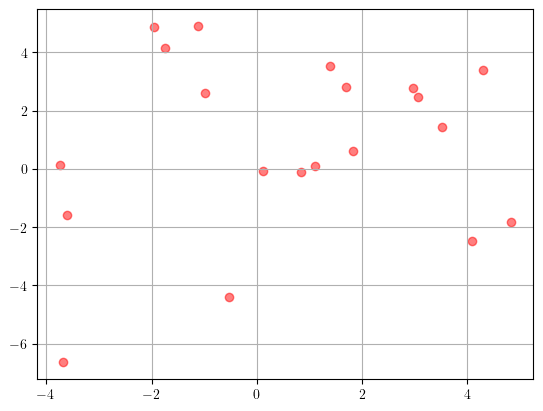

In [9]:
mean_ = [2.,2.]
cov_ = [[1.,0.],[0.,1.]]
mean_2 = [0.,0.]
cov_2 = [[10.,0.],[0.,10.]]
w = 0.5

l = np.random.default_rng(seed = 86_960_731).multinomial(20, [1-w,w], size=1)
print(l)
x_ = []
y_ = []
for i in range(2):
    if i == 0:
        x, y = np.random.default_rng(seed = 86_960_947).multivariate_normal(mean_, cov_, l[0][0]).T 
    else:
        x, y = np.random.default_rng(seed = 86_960_947).multivariate_normal(mean_2, cov_2, l[0][1]).T

    #print(x.tolist())
    x_.extend(x.tolist())
    y_.extend(y.tolist())
    
#print("x: ", x_, "y: ", y_)
#x_1, y_1 = np.random.default_rng(seed=42).multivariate_normal(mean_, cov_, 100).T
#x_2, y_2 = np.random.default_rng(seed=42).multivariate_normal(mean_2, cov_2, 100).T

#x_ = (w_ * x_1) + (w * x_2)
#y_ = (w_ * y_1) + (w * y_2)
#x_ = x_1.tolist() + x_2.tolist()
#y_ = y_1.tolist() + y_2.tolist()
plt.scatter(x_, y_, c="r", alpha =.5)
plt.grid(visible=True)

#### One Dimensional Normal distribution

In [10]:
mean_1d = 3.
var_1d = 1.
mean2_1d = -1.
var2_1d = 2.

w = 0.5
l = np.random.default_rng(seed=69).binomial(size=20, n=1, p=w)
x_1d = []
y_1d = []
for i in l:
    if i == 0:
        x = np.random.default_rng().normal(mean_1d, var_1d, 1).T 
    else:
        x = np.random.default_rng().normal(mean2_1d, var2_1d, 1).T

    x_1d.append(x[0])

### Histogram of data density

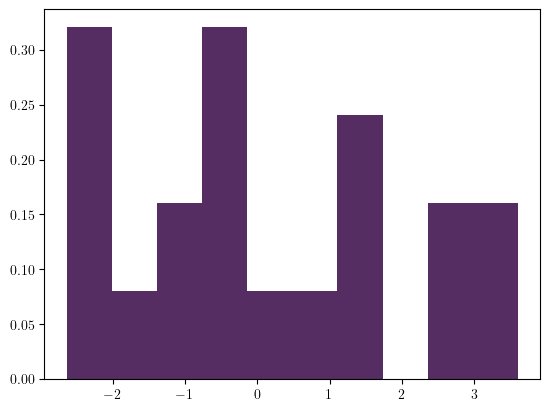

In [11]:
plt.hist(x_1d, bins=10, density=True, color='#552D62')
plt.grid(visible=False)

### Data density against joint distribution

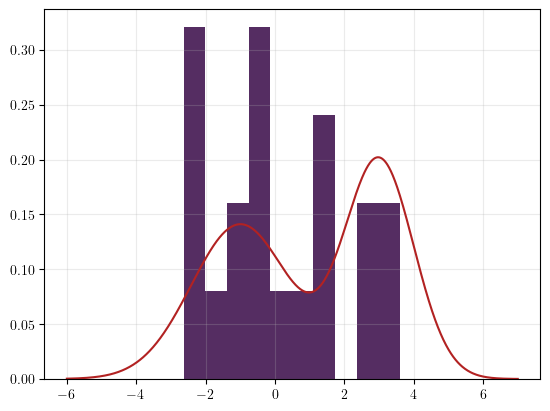

In [12]:
x = np.linspace(-6, 7, 1000)

plt.plot(x, Mix(x, w, mean_1d, var_1d, mean2_1d, var2_1d), color='firebrick')
plt.hist(x_1d, density=True, bins=10, color='#552D62')
plt.grid(visible=True, alpha=.25)

## Calling the mixture of Normals for plotting

In [13]:
x = np.linspace(-7, 7, 100)
y = np.linspace(-7, 7, 100)
X, Y = np.meshgrid(x, y)

### Individual Components

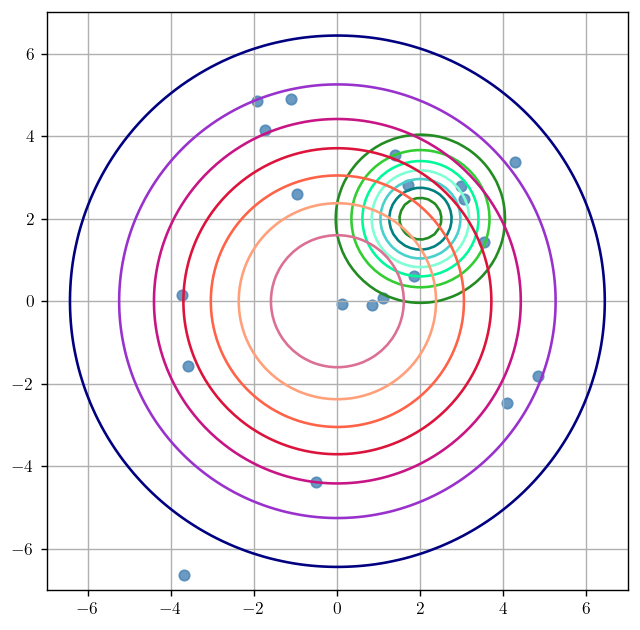

In [14]:
Z_1 = Normal(np.array([2.,2.]), 1, [X,Y], 2)
Z_2 = Normal(np.array([0.,0.]), 10, [X, Y], 2)

plt.figure(figsize=(6,6), dpi=125)
plt.contour(X,Y,Z_1, colors=cmap2)
plt.contour(X,Y,Z_2, colors=cmap3)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
plt.scatter(x_, y_, c="steelblue", alpha = .8)
plt.grid(visible=True)

### Joint Distribution

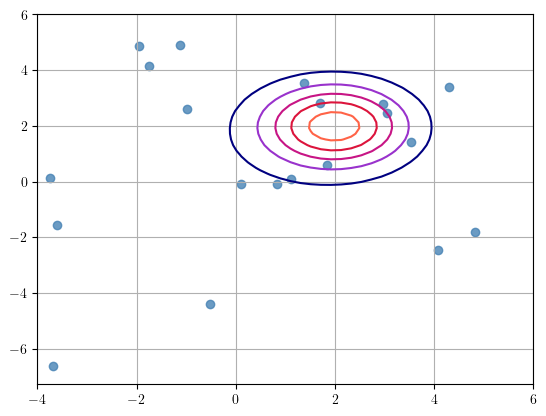

In [15]:
x = y = np.linspace(-4,6)
X_, Y_ = np.meshgrid(x, y)

Z_ = Mixture([X_, Y_], 0.5, [2.,2.], 1., [0.,0.], 10., 2)

plt.contour(X_,Y_,Z_, colors=cmap1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
plt.scatter(x_, y_, c="steelblue", alpha=.8)
plt.grid(visible=True)

## Expectation Propagation Approach for the Clutter Problem as stated in Minka (2001b)

We follow the steps, originally shown in Minka (2001b), from Chapter 10.7 in Bishop (2006).

The problem is formulated as follows:

The true likelihood and assumed prior are given below:

$p(\pmb{x}|\pmb{\theta})=(1-w)\mathcal{N}(\pmb{x}|\pmb{\theta}, \pmb{I}_d)+w\mathcal{N}(\pmb{x}|\pmb{0}, a\pmb{I}_d) \\
p(\pmb{\theta})=\mathcal{N}(\pmb{\theta}|\pmb{0}, b\pmb{I}_d)$

Over N observation we get the joint distribution of data $\mathcal{D}= \{\pmb{x}_1,...,\pmb{x}_N\}$:

$p(\mathcal{D},\pmb{\theta})=p(\pmb{\theta})\prod_{n=1}^Np(\pmb{x}_n|\pmb{\theta})\,, \; \mathrm{where}\; p(\pmb{x}_n|\pmb{\theta})=(1-w)\mathcal{N}(\pmb{x}_n|\pmb{\theta}, \pmb{I}_d)+w\mathcal{N}(\pmb{x}_n|\pmb{0}, a\pmb{I}_d)$

We select approximation 

$q(\pmb{\theta}):=\mathcal{N}(\pmb{\theta}|\pmb{m}, v\pmb{I}_d)$,

with approximating factors --- not true distributions --- $t_n(\pmb{\theta})$:

$t_n(\pmb{\theta}):=s_n \exp \{-\frac{1}{2v_n}(\pmb{\theta}-\pmb{m}_n)^T(\pmb{\theta}-\pmb{m}_n)\},\; n\in [N],\; t_0(\pmb{\theta})=p(\pmb{\theta})$

Such that we have:

$q(\pmb{\theta})=\prod_{n=0}^Nt_n(\pmb{\theta})$

The EP algorithm, stated in Algorithm ... in the paper reduces to the following:

We initialize $q(\pmb{\theta})=p(\pmb{\theta})$ by setting $t_i(\pmb{\theta})=1, \; \forall i\in 1,...,N$

We initialize this through setting $s_n=(2\pi v_n)^{D/2}$ where we are setting $v_n=\infty\implies v_n^{-1}=0$, and $\pmb{m}_n=\pmb{0}$. Each client has one datapoint in this experiment, we have 100 datapoints therefore 100 clients. 

### Step 1:
The algorithm reduces to be finding the cavity distribution $q^{\backslash n}(\pmb{\theta})$ through finding the mean and variance:

$\pmb{m}^{\backslash n} = \pmb{m} + v^{\backslash n}v_n^{-1}(\pmb{m}-\pmb{m}_n) \\
(v^{\backslash n})^{-1}=v^{-1} - v_n^{-1} \\
Z_n = (1-w) \mathcal{N}(\pmb{x}_n|\pmb{m}^{\backslash n}, (v^{\backslash n} +1)\pmb{I}_d) + w\mathcal{N}(\pmb{x}_n|\pmb{0}, a\pmb{I}_d)
$

### Step 2:
We find the new approximate posterior $q^{\mathrm{new}}(\pmb{\theta})$ by computing the new mean and variance parameters through the following equations:

$\pmb{m}^{\mathrm{new}}=\pmb{m}^{\backslash n}+\rho_n\frac{v^{\backslash n}}{v^{\backslash n}+1}(\pmb{x}_n-\pmb{m}^{\backslash n}) \\
v^{\mathrm{new}}=v^{\backslash n}-\rho_n\frac{(v^{\backslash n})^2}{v^{\backslash n}+1}+\rho_n(1-\rho_n) \frac{(v^{\backslash n})^2||\pmb{x}_n-\pmb{m}^{\backslash n}||^2}{D(v^{\backslash n}+1)^2}
$

where $\rho_n$ is given by:
$\rho_n:=1-\frac{w}{Z_n}\mathcal{N}(\pmb{x}_n|\pmb{0},a\pmb{I}_d)
$

### Step 3:
We can then compute the new factor $t_n^{\mathrm{new}}(\pmb{\theta})$ as:

$v_n^{-1}=(v^{\mathrm{new}})^{-1}-(v^{\backslash n})^{-1}\\
\pmb{m}_n=\pmb{m}^{\backslash n}+(v_n+v^{\backslash n})(v^{\backslash n})^{-1}(\pmb{m}^{\mathrm{new}}-\pmb{m}^{\backslash n}) \\
s_n = Z_n\,/\,{(2\pi v_n)^{D/2}}\mathcal{N}(\pmb{m}_n|\pmb{m}^{\backslash n}, (v_n+v^{\backslash n})\pmb{I}_d)
$

### EP Implementation

In [16]:
def norm_2(vector):
    s = 0.
    for p in vector:
        s += p ** 2
        
    return s

In [17]:
def trueDistribution2D(parameters, clients, min_1, max_1, min_2=None, max_2=None, plot=False):
    if min_2 == None:   
        x = y = np.linspace(min_1,max_1)
    else:
        x = np.linspace(min_1,max_1)
        y = np.linspace(min_2,max_2)
    X, Y = np.meshgrid(x, y)
    theta = [X, Y]
    
    prior = Normal(np.zeros(2), parameters["b"], theta, 2)
    distribution = prior
    
    for client in clients:
        mix = Mixture(client["x_n"], parameters["w"], theta, 1, np.zeros(2), 10, 2)
        
        temp = distribution * mix
        
        distribution = temp
        
    if plot:
        plt.figure(figsize=(6,6), dpi=100)
        plt.contour(X,Y,distribution, colors=cmap2)
        plt.grid(visible=True)

    return distribution
    

In [18]:
def trueDistribution1D(parameters, clients, min_, max_):
    x = np.linspace(min_,max_, 1000)
    theta = x
    
    prior = Normal(0., parameters["b"], theta, 1)
    distribution = prior
    
    for client in clients:
        
        mix = Mixture(client["x_n"], parameters["w"], theta, 1, 0., parameters["a"], 1)
        
        temp = distribution * mix
        
        distribution = temp
    
    plt.plot(x,distribution, color="firebrick")
    plt.grid(visible=True)
    
    return distribution

In [19]:
#Model evidence calculation approximation:
def evidence(q_global, clients, parameters):
    B = (((q_global["mean"][0] ** 2) + (q_global["mean"][1] ** 2)) / q_global["variance"])
    prod = 1.
    for i in range(parameters["N"]):
        t = ((clients[i]["mean"][0] ** 2) + (clients[i]["mean"][1] ** 2)) * clients[i]["variance_inverse"]
        B -= t
        
        #Include infinite variance
        if clients[i]["variance_inverse"] == 0:
            continue
        temp = clients[i]["normaliser"] / (2 * clients[i]["variance"] * np.pi)
        temp_prod = temp * prod
        prod = temp_prod
    
    ret = (2 * q_global["variance"] * np.pi) * np.exp(B/2) * prod
    
    #print("===========================================")
    #print("p(D): ", ret)
    return ret

In [20]:
#Model evidence calculation approximation:
def evidence1D(q_global, clients, parameters):
    B = ((q_global["mean"] ** 2) / q_global["variance"])
    prod = 1.
    for i in range(parameters["N"]):
        t = (clients[i]["mean"] ** 2) * clients[i]["variance_inverse"]
        B -= t
        
        #Include infinite variance
        if clients[i]["variance_inverse"] == 0:
            continue
        temp = clients[i]["normaliser"] / (2 * clients[i]["variance"] * np.pi)
        temp_prod = temp * prod
        prod = temp_prod
    
    ret = (2 * q_global["variance"] * np.pi) * np.exp(B/2) * prod
    
    return ret

In [21]:
def ExpectationPropagation(clients, q_global, parameters):
    
    #Setting the Default to be Minka's default setting in Minka (2001b)
    if parameters["w"] is not None:
        w = parameters["w"]
    else:
        print("Warning! No 'w' specified. Might not match data generating mechanism.")
        w = 0.5
        
    if parameters["a"] is not None:
        a = parameters["a"]
    else: 
        print("Warning! No 'a' specified. Might not match data generating mechanism.")       
        a = 10
        
    if parameters["b"] is not None:
        b = parameters["b"]
    else:
        b = 100
    
    if parameters["D"] is not None:
        D = parameters["D"]
    else:
        D = len(q_global["mean"])
    
    if parameters["N"] is not None:
        N = parameters["N"]
    else:
        N = len(clients)
    
    if parameters["Epochs"] is not None:
        Epochs = parameters["Epochs"]
    else:
        Epochs = 50
    
    for i in range(Epochs):
        print("===========================================")
        print(f"Iteration {i+1}:")
        for n in range(N):
            ###############################################
            # Step 1:
            ###############################################
            #print(f"STEP {n}:")
            v_bar_n_inverse = q_global["variance"] ** (-1) - clients[n]["variance_inverse"]
            v_bar_n = v_bar_n_inverse ** (-1)
            
            part = (v_bar_n) * clients[n]["variance_inverse"] * (q_global["mean"] - clients[n]["mean"])
            
            m_bar_n = q_global["mean"] + part

            Z_n = Mixture(clients[n]["x_n"], w, m_bar_n, (v_bar_n + 1), np.zeros(D), a, D)

            ###############################################
            #Step 2:
            ###############################################

            rho_n = 1 - (w/Z_n) * Normal(np.zeros(D), a, clients[n]["x_n"], D)

            m_new = m_bar_n + rho_n * v_bar_n * (clients[n]["x_n"] - m_bar_n) / (v_bar_n + 1)

            term_1 = rho_n * (v_bar_n ** 2) / (v_bar_n + 1)
            
            norm = (np.linalg.norm(clients[n]["x_n"] - m_bar_n) ** 2)
            term_2 = rho_n * (1 - rho_n) * (v_bar_n ** 2) * norm
            term_3 = D * ((v_bar_n + 1) ** 2)
            
            v_new = v_bar_n - term_1 + (term_2 / term_3)

            ###############################################
            #Step 3:
            ###############################################

            v_n_inverse = (v_new ** (-1)) - v_bar_n_inverse
            
            if v_n_inverse == 0.0:
                v_n = np.inf
            else:
                v_n = v_n_inverse ** (-1)
            
            # using the convention that 0 * np.inf = 0
            if rho_n == 0.0:    
                m_n = m_bar_n
            else:
                m_n = m_bar_n + (v_n + v_bar_n) * v_bar_n_inverse * (m_new - m_bar_n)

            if v_n == np.inf:
                s_n = Z_n
            else:
                s_n = Z_n / (((np.absolute(2 * v_n * np.pi)) ** (D / 2)) * Normal(m_bar_n, (v_n + v_bar_n), m_n, D))

            ###############################################
            # Updating Results for client and global approximation:
            ###############################################

            q_global["mean"] = m_new
            q_global["variance"] = v_new

            clients[n]["mean"] = m_n
            clients[n]["variance"] = v_n
            clients[n]["variance_inverse"] = v_n_inverse
            clients[n]["normaliser"] = s_n
            clients[n]["iteration"] = i + 1

        print("New global q: ", q_global)
    return q_global, clients

### Two Dimensional Example
#### Initializing each client

In [22]:
#Parameters Definitions:
parameters_ep = {
    "w": 0.5,
    "a": 10,
    "b": 100,
    "D": 2,
    "N": 20,
    "Epochs": 10
}

q_global_ep = {
    "mean": np.array([0.,0.]),
    "variance": parameters_ep["b"]
}

clients_ep = []

for i in range(len(x_)):
    clients_ep.append({
        "client_idx": i,
        "x_n": np.array([x_[i], y_[i]]),
        "mean": np.array([0.,0.]),
        "variance": np.inf,
        "variance_inverse": 0.,
        "normaliser": 1.,
        "iteration": 0
    })


In [23]:
q_new_ep, clients_new_ep = ExpectationPropagation(clients_ep, q_global_ep, parameters_ep)
evidence(q_new_ep, clients_new_ep, parameters_ep)

Iteration 1:
New global q:  {'mean': array([-0.49436461,  1.24144535]), 'variance': 3.639438945657272}
Iteration 2:
New global q:  {'mean': array([2.72594118, 2.49018122]), 'variance': 0.49577924888831615}
Iteration 3:
New global q:  {'mean': array([2.54724368, 2.33116033]), 'variance': 0.34675419250287587}
Iteration 4:
New global q:  {'mean': array([2.51410646, 2.29406856]), 'variance': 0.3715522077831014}
Iteration 5:
New global q:  {'mean': array([2.51364369, 2.29317909]), 'variance': 0.3794261484558759}
Iteration 6:
New global q:  {'mean': array([2.51443881, 2.29388655]), 'variance': 0.3813619017347107}
Iteration 7:
New global q:  {'mean': array([2.51462475, 2.29411117]), 'variance': 0.38148747895816637}
Iteration 8:
New global q:  {'mean': array([2.51465458, 2.29415476]), 'variance': 0.38144792910074427}
Iteration 9:
New global q:  {'mean': array([2.51465387, 2.29415674]), 'variance': 0.3814348859517385}
Iteration 10:
New global q:  {'mean': array([2.51465272, 2.29415559]), 'varia

1.3556138875246851e-84

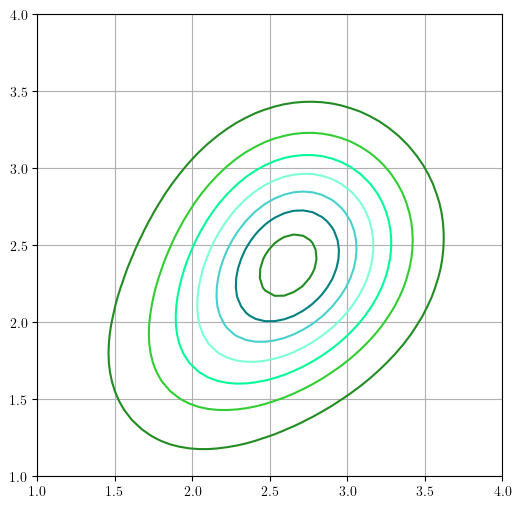

In [24]:
Z_true = trueDistribution2D(parameters_ep, clients_ep, 1, 4, plot=True)

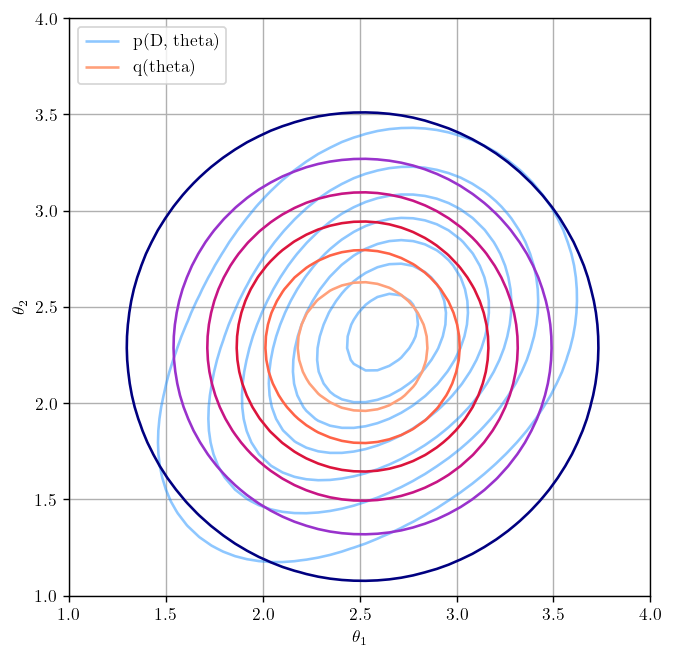

In [25]:
x = y = np.linspace(1,4)
X_q, Y_q = np.meshgrid(x, y)
plt.figure(figsize=(6,6), dpi=125)
trial_var = 1 / q_new_ep["variance"]
Z_q = Normal(q_new_ep["mean"], q_new_ep["variance"], [X_q, Y_q], parameters_ep["D"])

c1 = plt.contour(X_q,Y_q,Z_true, colors='dodgerblue', alpha=.5)
c2 = plt.contour(X_q,Y_q,Z_q, colors=cmap1)
h1,_=c1.legend_elements()
h2,_=c2.legend_elements()
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
plt.legend([h1[0],h2[0]], ["p(D, theta)", "q(theta)"], loc="upper left")
plt.grid(visible=True)

### One Dimensional Example

In [26]:
#Parameters Definitions:
parameters_ep_ = {
    "w": 0.5,
    "a": 2.,
    "b": 100.,
    "D": 1,
    "N": 20,
    "Epochs": 10
}

q_global_ep_ = {
    "mean": 0.,
    "variance": parameters_ep_["b"]
}

clients_ep_ = []
for i in range(len(x_1d)):
    clients_ep_.append({
        "client_idx": i,
        "x_n": x_1d[i],
        "mean": 0.,
        "variance": np.inf,
        "variance_inverse": 0.,
        "normaliser": 1.,
        "iteration": 0
    })

In [27]:
q_new_ep_, clients_new_ep_ = ExpectationPropagation(clients_ep_, q_global_ep_, parameters_ep_)

Iteration 1:
New global q:  {'mean': array([2.05971312]), 'variance': array([1.61213579])}
Iteration 2:
New global q:  {'mean': array([1.92132634]), 'variance': array([2.89401425])}
Iteration 3:
New global q:  {'mean': array([2.7822612]), 'variance': array([0.23504099])}
Iteration 4:
New global q:  {'mean': array([2.43270418]), 'variance': array([0.46295409])}
Iteration 5:
New global q:  {'mean': array([2.44686284]), 'variance': array([0.48138438])}
Iteration 6:
New global q:  {'mean': array([2.45237159]), 'variance': array([0.48554422])}
Iteration 7:
New global q:  {'mean': array([2.45350652]), 'variance': array([0.48582124])}
Iteration 8:
New global q:  {'mean': array([2.45358108]), 'variance': array([0.48575597])}
Iteration 9:
New global q:  {'mean': array([2.4535652]), 'variance': array([0.48574777])}
Iteration 10:
New global q:  {'mean': array([2.45356087]), 'variance': array([0.4857491])}


In [28]:
evidence1D(q_new_ep_, clients_new_ep_, parameters_ep_)

array([-5.26943263e-54])

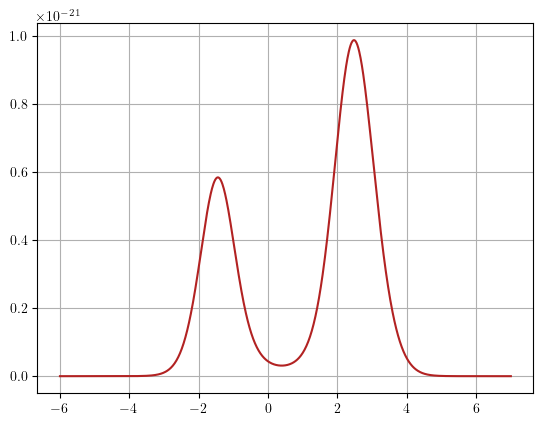

In [29]:
true_joint = trueDistribution1D(parameters_ep_, clients_ep_, -6,7)

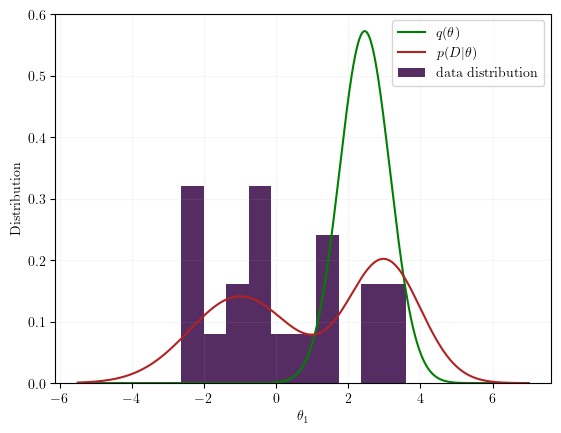

In [30]:
x = np.linspace(-5.5, 7, 1000)


plt.plot(x, Normal(q_new_ep_["mean"], q_new_ep_["variance"], x, 1), 
         label=r"$q(\theta)$", color='green')
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, w, mean_1d, var_1d, mean2_1d, var2_1d), color="firebrick", label=r"$p(D|\theta)$")
plt.hist(x_1d, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"Distribution")
plt.legend(loc="upper right")
plt.grid(visible=True, alpha=.1)
plt.savefig('outlier_EP_1D.pgf', pad_inches=0)

## Partitioned Variational Inference for the Clutter Problem

We initialize the approximating distributions as in the EP algorithm, we repeat this here for clarity:
The problem is formulated as follows:

The true likelihood and assumed prior are given below:

$p(\pmb{x}|\pmb{\theta})=(1-w)\mathcal{N}(\pmb{x}|\pmb{\theta}, \pmb{I}_d)+w\mathcal{N}(\pmb{x}|\pmb{0}, a\pmb{I}_d) \\
\pi(\pmb{\theta})=\mathcal{N}(\pmb{\theta}|\pmb{0}, b\pmb{I}_d)$

Over N observation we get the joint distribution of data $\mathcal{D}= \{\pmb{x}_1,...,\pmb{x}_N\}$:

$p(\mathcal{D},\pmb{\theta})=p(\pmb{\theta})\prod_{k=1}^Np(\pmb{x}_k|\pmb{\theta})$

We select approximation 

$q(\pmb{\theta}):=\mathcal{N}(\pmb{\theta}|\pmb{m}, v\pmb{I}_d)$,

with approximating factors --- not true distributions --- $t_n(\pmb{\theta})$:

$t_n(\pmb{\theta}):=s_n \exp \{-\frac{1}{2v_n}(\pmb{\theta}-\pmb{m}_n)^T(\pmb{\theta}-\pmb{m}_n)\},\; n\in [M],\; t_0(\pmb{\theta})=p(\pmb{\theta})$

Such that we have:

$q(\pmb{\theta})=\pi(\pmb{\theta})\prod_{n=1}^Mt_n(\pmb{\theta})$

The PVI algorithm, stated in Algorithm ... in my paper reduces to the following:
### PVI Algorithm Initialization:
We initialize $q(\pmb{\theta})=p(\pmb{\theta})$ by setting $t_i(\pmb{\theta})=1, \; \forall i\in 1,...,M$

We initialize this through setting $s_n=1$ where we are setting $v_n=\infty\implies v_n^{-1}=0$, and $\pmb{m}_n=\pmb{0}$. Each client has one datapoint in this experiment, we have 100 datapoints therefore 100 clients. 

For each iteration $i$ until convergence do:

For each client $n\in{1,...,M}$, do:

### Step 1

$q^{new}(\pmb{\theta})=\mathrm{arg\, max}_{q\in\mathcal{Q}}\int \log \frac{q^{(i-1)}(\pmb{\theta})p(\pmb{y}_n|\pmb{\theta})}{t_n^{(i-1)}(\pmb{\theta})q(\pmb{\theta})}dq(\pmb{\theta}) = 
\mathrm{arg\, min}_{q\in\mathcal{Q}}\mathrm{KL}\bigl(q(\pmb{\theta})\big|\big|\frac{1}{Z_n}\frac{q^{(i-1)}(\pmb{\theta})}{t_n^{(i-1)}(\pmb{\theta})}p(\pmb{y}_n|\pmb{\theta})\bigr), Z_n=\int\frac{q^{(i-1)}(\pmb{\theta})}{t_n^{(i-1)}(\pmb{\theta})}p(\pmb{y}_n|\pmb{\theta})d\pmb{\theta}$

$=\mathrm{arg\,max}_{q\in\mathcal{Q}} \Big\{ \sum_{k\neq \{0,n\}}^N\mathbb{E}_{q(\pmb{\theta})}\big[\log t_k^{(i-1)}(\pmb{\theta})\big]+\sum_{j\in n}\mathbb{E}_{q(\pmb{\theta})}\big[ \log p(\pmb{y}_{n_k}|\pmb{\theta}) \big]  - \mathrm{KL}\bigl(q(\pmb{\theta})\big|\big|\pi(\pmb{\theta})\bigr)\Big\}
$

$ =\mathrm{arg\,min}_{q\in\mathcal{Q}} \Big\{\mathrm{KL}\bigl(q(\pmb{\theta})\big|\big|q^{\backslash n}(\pmb{\theta})\bigr) -\sum_{j\in n}\mathbb{E}_{q(\pmb{\theta})}\big[ \log p(\pmb{y}_{n_j}|\pmb{\theta}) \big] \Big\}
$
### Step 2

Update $t_n(\pmb{\theta})$:

$t^{(i)}_n(\pmb{\theta})\propto \frac{q^{new}(\pmb{\theta})}{q^{(i-1)}(\pmb{\theta})}t^{(i-1)}_n(\pmb{\theta})$

and pass $\Delta_n(\pmb{\theta}) = \frac{t^{(i)}_n(\pmb{\theta})}{t^{(i-1)}_n(\pmb{\theta})}$ to the server.

### Step 3

At the server, update the global approximate likelihood $q^{(i)}(\pmb{\theta})$:

$q^{(i)}(\pmb{\theta})=q^{(i-1)}(\pmb{\theta})\Delta_n(\pmb{\theta})$

#### KLD between two Multivariate Gaussians
The KLD between two $d$-dimensional Multivariate Gaussians $q(\theta)\sim \mathcal{N}(\mu,\Sigma)$ and $p(\theta)\sim\mathcal{N}(\eta,\Lambda)$ is defined as follows:

$\mathrm{KLD}(q(\theta)||p(\theta))= \frac{1}{2}\bigl((\eta-\mu)^\top\Lambda^{-1}(\eta-\mu)+\mathrm{tr}(\Lambda^{-1}\Sigma)+\log \frac{|\Lambda|}{|\Sigma|}-d\bigr)
$

Which, in the case of spherical Gaussians, i.e. $q(\theta)\sim \mathcal{N}(\mu,\alpha\mathrm{I}_d)$ and $p(\theta)\sim\mathcal{N}(\eta,\beta\mathrm{I}_d)$, redused to the following:

$\mathrm{KLD}(q(\theta)||p(\theta))= \frac{1}{2}\bigl(\frac{1}{\beta}(\eta-\mu)^\top(\eta-\mu) +d\frac{\alpha}{\beta}-d\log\frac{\alpha}{\beta} -d\bigr)
$

#### The Alpha Renyi Divergence between two spherical Gaussians is

$\mathrm{D}_{AR}^{(\alpha)}(q(\theta)||\pi(\theta))= \frac{(\mu-\eta)^\top(\mu-\eta)}{2(\alpha\lambda +(1-\alpha)\sigma)} - \frac{D}{2\alpha(\alpha-1)}\log\frac{\alpha \lambda +(1-\alpha)\sigma}{\sigma^{1-\alpha}\:\lambda^{\alpha}}$

$= \frac{(\mu-\eta)^\top(\mu-\eta)}{2(\alpha\lambda +(1-\alpha)\sigma)} - \frac{D}{2\alpha(\alpha-1)}(\log (\alpha \lambda +(1-\alpha)\sigma) - \log (\sigma^{1-\alpha}\:\lambda^{\alpha}))$

$= \frac{(\mu-\eta)^\top(\mu-\eta)}{2(\alpha\lambda +(1-\alpha)\sigma)} + \frac{D}{2\alpha(\alpha-1)}(\log (\sigma^{1-\alpha}\:\lambda^{\alpha})-\log (\alpha \lambda +(1-\alpha)\sigma))$

$= \frac{(\mu-\eta)^\top(\mu-\eta)}{2(\alpha\lambda +(1-\alpha)\sigma)} - \frac{D}{2\alpha}\log (\sigma) + \frac{D}{2(\alpha-1)}\log(\lambda)-\frac{D}{2\alpha(\alpha-1)}\log (\alpha \lambda +(1-\alpha)\sigma))$

In [31]:
def Divergence(q_original, p_likelihood, client, parameters):
    
    div = parameters["Divergence"]
    
    q_approximation = copy.deepcopy(q_original)
    
    if div == "KLD":
        print("Not implemented")
    elif div == "Alpha":
        print("Not implemented")
    elif div == "AR":
        print("Not implemented")
    
    return None  

def kl_gaussians(loc_1, loc_2, cov_1, cov_2):
        # Compute KL(p||q)= E_p(x)[log p(x) - log q(x)]
    assert loc_1.shape == loc_2.shape, "Not same dimension of means"
    assert cov_1.shape == cov_2.shape, "Not same Cov Matrix dimension"
    assert cov_1.shape[0] == cov_1.shape[1], "Not square matrix"

    d = cov_1.shape[0]
    diff = loc_2 - loc_1
    part_1 = torch.matmul(diff.unsqueeze(0), torch.linalg.solve(cov_2, diff.unsqueeze(-1))).squeeze()
    part_2 = torch.trace(torch.linalg.solve(cov_2, cov_1)).squeeze()
    part_3 = (torch.log(torch.linalg.det(cov_2)) - torch.log(torch.linalg.det(cov_1))).squeeze()

    #print(part_1, part_2, part_3, d)

    return (part_1 + part_2 + part_3 - d) / 2
    
def kl_spherical_gaussian(loc_1, loc_2, cov_1, cov_2, config):    
    
    diff = loc_2 - loc_1
    
    part_1 = torch.matmul(diff.unsqueeze(0), diff.unsqueeze(-1)).squeeze() / cov_2
    
    part_2 = config["D"] * cov_1 / cov_2
    
    part_3 = config["D"] * torch.log(torch.abs(cov_1) / torch.abs(cov_2))
    
    return (part_1 + part_2 - part_3 - config["D"]) / 2
    
def alpha_renyi(loc_1, loc_2, cov_1, cov_2, config):
    
    alpha = config["alpha"]
    
    diff = loc_2 - loc_1
    
    lin = (alpha * cov_2) + ((1 - alpha) * cov_1)
    
    part_1 = torch.matmul(diff.unsqueeze(0), torch.linalg.solve(lin, diff.unsqueeze(-1))).squeeze()
    
    part_2 = torch.log(torch.linalg.det(lin)).squeeze() / (alpha * (alpha - 1))
    
    part_3 = torch.log(torch.linalg.det(cov_1)).squeeze() / alpha
    
    part_4 = torch.log(torch.linalg.det(cov_2)).squeeze() / (1 - alpha)
    
    return (part_1 - part_2 - part_3 - part_4) / 2
    
def alpha_renyi_spherical(loc_1, loc_2, var_1, var_2, config):
    
    diff = loc_1 - loc_2
    
    part_1_ = torch.matmul(diff.unsqueeze(0), diff.unsqueeze(-1)).squeeze()
    
    lin = (config["alpha"] * var_2 + (1 - config["alpha"]) * var_1)
    
    part_1 = part_1_ / (2 * lin)
    
    coef_1 = config["D"] / (2 * config["alpha"])
    
    coef_2 = config["D"] / (2 * (config["alpha"] - 1))
    
    coef_3 = config["D"] / (2 * config["alpha"] * (config["alpha"] - 1))
    
    part_2 = coef_1 * torch.log(var_1)
    
    part_3 = coef_2 * torch.log(var_2)
    
    part_4 = coef_3 * torch.log(lin)
    
    return part_1 - part_2 + part_3 - part_4

def gamma_spherical(loc_1, loc_2, var_1, var_2, config):
    
    var_1 = torch.abs(var_1)
    var_2 = torch.abs(var_2)
    
    D = config["D"]
    gamma = config["gamma"]
    
    diff = loc_1 - loc_2
    part_1_ = torch.matmul(diff.unsqueeze(0), diff.unsqueeze(-1)).squeeze()
    lin = (var_2 + (gamma - 1) * var_1)
    part_1 = (part_1_ / (2 * lin)).squeeze()
    
    part_2 = (D / (2*gamma - 2)) * torch.log(lin).squeeze()
    
    part_3 = (D / (gamma -1)) * torch.log(var_1).squeeze()
    
    #Only parts 1-3 are relevant for optimisation but taking out the constants might make convergence metrics
    #have different numbers that the ELBO converges to
    
    part_4 = (gamma/(gamma-1))*torch.log(torch.tensor(2*np.pi))
    
    part_5 = ((D*gamma)/(2*gamma - 2))*torch.log(var_2).squeeze()
    
    part_6 = (D/2)*torch.log(torch.tensor(2*np.pi)).squeeze()
    
    part_7 = (D/(2*gamma - 2))*torch.log(torch.tensor(gamma)).squeeze()
    
    const = part_6 - part_7 - part_5 - part_4
    #const = 0.
    
    return part_1 + part_2 + part_3 + const
    

In [32]:
def PartitionedVariationalInference(q_global, clients, parameters, is_1d=False, minibatch=False, different_loss=False):
    # Implementation of Partitioned Variational Inference for Federated Learning (Bui et al. 2018, Ashman et al. 2022)
    
    # Initialization:
    
    D = parameters["D"]
    
    if parameters["Divergence"] != "AR":
        alpha = None
    else:
        alpha = parameters["alpha"]
    if parameters["Divergence"] != "G":
            gamma = None
    else:
        gamma = parameters["gamma"]
        
    if minibatch:
        batchsize = parameters["batch_size"]
    else:
        batchsize = np.inf
        
    if different_loss:
        loss = parameters["loss"]
    else:
        loss = None
        
    config = {
        "D": D,
        "epochs": parameters["Epochs"], 
        "samples": parameters["samples"],
        "lr_scheduler_params": {"lr_lambda": lambda epoch: 1.0},
        "optim_epochs": parameters["optim_epochs"],
        "is_1d": is_1d,
        "alpha": alpha,
        "gamma": gamma,
        "early_stopping": False,
        "minibatch": minibatch,
        "batchsize": batchsize,
        "loss": loss
    }
        
    print("Starting global q: ", q_global)
    
    for i in range(config["epochs"]):
    
        print("===========================================")
        print(f"Iteration {i+1}:")
        for n in range(len(clients)):
            q_global, t_new = Client.update_q(clients[n], q_global, parameters, config)
            
            clients[n]["mean"] = t_new["mean"]
            clients[n]["variance"] = t_new["variance"]
            clients[n]["variance_inverse"] = t_new["variance_inverse"]
            clients[n]["iteration"] += 1
            

        print("New global q: \n loc: ", q_global["loc"], "\n var: ", q_global["var"])
            
    return q_global, clients
    

In [33]:
def SynchronousPVI(q_global, clients, parameters, is_1d=False, minibatch=False, different_loss=False):
    # Implementation of Partitioned Variational Inference for Federated Learning (Bui et al. 2018, Ashman et al. 2022)
    
    # Initialization:
    
    D = parameters["D"]
    
    if parameters["Divergence"] != "AR":
        alpha = None
    else:
        alpha = parameters["alpha"]
    if parameters["Divergence"] != "G":
            gamma = None
    else:
        gamma = parameters["gamma"]
        
    if minibatch:
        batchsize = parameters["batch_size"]
    else:
        batchsize = np.inf
    
    if different_loss:
        loss = parameters["loss"]
    else:
        loss = None
        
    config = {
        "D": D,
        "epochs": parameters["Epochs"], 
        "samples": parameters["samples"],
        "lr_scheduler_params": {"lr_lambda": lambda epoch: 1.0},
        "optim_epochs": parameters["optim_epochs"],
        "is_1d": is_1d,
        "alpha": alpha,
        "gamma": gamma,
        "early_stopping": False,
        "minibatch": minibatch,
        "batchsize": batchsize,
        "loss": loss
    }
        
    print("Starting global q: ", q_global)
    
    for i in range(config["epochs"]):
    
        print("===========================================")
        print(f"Iteration {i+1}:")
        elbo_i = 0.
        
        q_global_list = []
        for n in range(len(clients)):
            temp = copy.deepcopy(q_global)
            q_global_list.append(temp)
            
        for n in range(len(clients)):
            print(f"Client {n}")
            q_new_n, t_new = Client.update_q(clients[n], q_global_list[n], parameters, config)
            clients[n]["mean"] = t_new["mean"]
            clients[n]["variance"] = t_new["variance"]
            clients[n]["variance_inverse"] = t_new["variance_inverse"]
            clients[n]["iteration"] += 1
            
            #Can we simply pass the q_global_list? instead of doing this to the clients?
            #clients[n]["q_n"]["loc"] = q_new_n["loc"].detach()
            #clients[n]["q_n"]["var"] = q_new_n["var"].detach()
            
            elbo_i += q_new_n["metrics"]["elbos"][i]
        
        q_global = aggregate_posteriors(q_global, q_global_list, elbo_i)
        
        print("New global q: \n loc: ", q_global["loc"], "\n var: ", q_global["var"])
        #if config["early_stopping"]:
                #break
            
    return q_global, clients

def aggregate_posteriors(q_global, q_global_list, elbo):    
    M = len(q_global_list)
    
    denom_var_inv = (M-1) * torch.linalg.inv(q_global["var"].detach())
    denom_var = torch.linalg.inv(denom_var_inv)
    
    denom_mean = torch.matmul(denom_var, (M-1) * torch.linalg.solve(
        q_global["var"].detach(), q_global["loc"].detach().unsqueeze(-1)))
    
    numer_var_inv = torch.zeros_like(q_global["var"].detach())
    for q in q_global_list:
        numer_var_inv += torch.linalg.inv(q["var"].detach())
        
    numer_var = torch.linalg.inv(numer_var_inv)
    
    numer_var_mean = torch.linalg.solve(
        q_global_list[0]["var"].detach(), q_global_list[0]["loc"].detach().unsqueeze(-1))
    
    for i in range(1, len(q_global_list)):
        numer_var_mean += torch.linalg.solve(
            q_global_list[i]["var"].detach(), q_global_list[i]["loc"].detach().unsqueeze(-1))
        
    numer_mean = torch.matmul(numer_var, numer_var_mean)
    
    q_new_var_inv = numer_var_inv - denom_var_inv
    
    q_new_var = torch.linalg.inv(q_new_var_inv)
    
    q_new_var_mean = torch.matmul(numer_var_inv, numer_mean) - torch.matmul(denom_var_inv, denom_mean)
    
    q_new_mean = torch.matmul(q_new_var, q_new_var_mean).squeeze(-1)
    
    q_new = copy.deepcopy(q_global)
    
    q_new["metrics"]["elbos"].append(elbo)
    q_new.update({"loc": torch.nn.Parameter(q_new_mean), "var": torch.nn.Parameter(q_new_var)})
    
    return q_new

In [34]:
def AsynchronousPVI(q_global, clients, parameters, is_1d=False, minibatch=False, different_loss=False):
    # Implementation of Partitioned Variational Inference for Federated Learning (Bui et al. 2018, Ashman et al. 2022)
    
    # Initialization:
    
    D = parameters["D"]
    
    if parameters["Divergence"] != "AR":
        alpha = None
    else:
        alpha = parameters["alpha"]
    if parameters["Divergence"] != "G":
            gamma = None
    else:
        gamma = parameters["gamma"]
        
    if minibatch:
        batchsize = parameters["batch_size"]
    else:
        batchsize = np.inf
        
    if different_loss:
        loss = parameters["loss"]
    else:
        loss = None
        
    config = {
        "D": D,
        "epochs": parameters["Epochs"], 
        "samples": parameters["samples"],
        "lr_scheduler_params": {"lr_lambda": lambda epoch: 1.0},
        "optim_epochs": parameters["optim_epochs"],
        "is_1d": is_1d,
        "alpha": alpha,
        "gamma": gamma,
        "early_stopping": False,
        "minibatch": minibatch,
        "batchsize": batchsize,
        "loss": loss
        
    }
        
    print("Starting global q: ", q_global)
    
    for i in range(config["epochs"]):
    
        print("===========================================")
        print(f"Iteration {i}:")
        elbo_i = 0.
        if i > 0:
            for n in range(len(clients)):
                if clients[n]["wait_time"] == 0 or i % clients[n]["wait_time"] == 0:
                    if clients[n]["wait_time"] <= i:
                        q_global = update_q_async(q_global, clients[n])
              
        for n in range(len(clients)):
            if clients[n]["wait_time"] == 0 or i % clients[n]["wait_time"] == 0:
                print(f"Client {n} with wait time: ", clients[n]["wait_time"])
                
                clients[n]["q_old"]["loc"] = q_global["loc"].detach()
                clients[n]["q_old"]["var"] = q_global["var"].detach()
                temp = copy.deepcopy(q_global)
                
                q_new_n, t_new = Client.update_q(clients[n], temp, parameters, config)
                clients[n]["q_new"]["loc"] = q_new_n["loc"].detach()
                clients[n]["q_new"]["var"] = q_new_n["var"].detach()
            
                clients[n]["mean"] = t_new["mean"]
                clients[n]["variance"] = t_new["variance"]
                clients[n]["variance_inverse"] = t_new["variance_inverse"]
                clients[n]["iteration"] += 1


        print("New global q: \n loc: ", q_global["loc"], "\n var: ", q_global["var"])
        #if config["early_stopping"]:
                #break      
    return q_global, clients

#Mixture of Experts calculation for q_m * q^i / q_m^old \propto q^(i+1)
def update_q_async(q_global, client):    
    
    var_inv = (torch.linalg.inv(client["q_new"]["var"]) + torch.linalg.inv(q_global["var"].detach()) 
               - torch.linalg.inv(client["q_old"]["var"]))
    
    q_new_var = torch.linalg.inv(var_inv)
    
    q_new_mean = torch.matmul(q_new_var, (torch.linalg.solve(client["q_new"]["var"], client["q_new"]["loc"].unsqueeze(-1)) 
                              + torch.linalg.solve(q_global["var"].detach(), q_global["loc"].detach().unsqueeze(-1))
                              - torch.linalg.solve(client["q_old"]["var"], client["q_old"]["loc"].unsqueeze(-1)))).squeeze(-1)
    
    q_current = copy.deepcopy(q_global)
    
    q_current.update({"loc": torch.nn.Parameter(q_new_mean), "var": torch.nn.Parameter(q_new_var)})
    
    return q_current

In [35]:
class Client:    
    def get_default_config():
        return {
            "epochs": 20,
            "optimiser": "Adam",
            "optimiser_params": {"lr": 0.05},
            "model_optimiser_params": {},
            "sigma_optimiser_params": {},
            "lr_scheduler": "MultiplicativeLR",
            "lr_scheduler_params": {"lr_lambda": lambda epoch: 1.0},
        }
    
    def update_q(client, q, parameters, config):

        q_new, t_new = Client.gradient_based_update(client, q, parameters, config)
        #print("New Distribution: ", q_new["loc"], q_new["var"])
        return q_new, t_new

    def gradient_based_update(client, q, parameters, config):
        q_old = copy.deepcopy(q)
        q_cav = Client.cavity(q, client)

        q_params = list(q.items())
        
        
        q_parameters = [
                        {"params": q["loc"]},
                        {"params": q["var"]}
                    ]    
        
        #print(q_parameters)
        optimiser = torch.optim.Adam(q_parameters, lr=parameters["lr"])
        #print(optimiser)
        
        lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(
            optimiser, **config["lr_scheduler_params"])
        
        #epoch_iter = tqdm(
        #    range(config["epochs"]),
        #    desc="Epoch",
        #    leave=True,
        #)
        for i in range(config["optim_epochs"]):
            
            # Calculate the minimization step and iteratively refine the mean and variance parameters
            # Compute argmin(-F(q)) = argmin {KL(q||q_cav) - Sum(E_q[log p(y_k_i | theta)])}
            
            #epoch = defaultdict(lambda: 0.0)
            """if client["iteration"] > 0:
                print(i)
                print(f"q_cav: loc: ",q_cav["loc"], " and var: ",q_cav["var"])
                print(f"Client: loc: ", client["mean"]," var: ", client["variance"], " var_inverse: ", client["variance_inverse"])
                print(f"q current: loc: ", q["loc"].detach(), " and var: ", q["var"].detach())"""
            optimiser.zero_grad()
            
            coef = 1.
            batch = client["x_n"]
            if config["minibatch"]:
                coef = len(client["x_n"]) / config["batchsize"]
                batch = get_batch(client["x_n"], config["batchsize"])
            
            if client["spherical"]:
                if parameters["Divergence"] == "KLD":
                    div = kl_spherical_gaussian(q["loc"], q_cav["loc"], q["var"], q_cav["var"], config)
                elif parameters["Divergence"] == "AR":
                    div = alpha_renyi_spherical(q["loc"], q_cav["loc"], q["var"], q_cav["var"], config)
                elif parameters["Divergence"] == "G":
                    div = gamma_spherical(q["loc"], q_cav["loc"], q["var"], q_cav["var"], config)
                else:
                    print("!!! No Divergence specified !!!")
                    div = 0
            else:
                if parameters["Divergence"] == "KLD":
                    div = kl_gaussians(q["loc"], q_cav["loc"], q["var"], q_cav["var"])
                elif parameters["Divergence"] == "AR":
                    div = alpha_renyi(q["loc"], q_cav["loc"], q["var"], q_cav["var"], config)
                else:
                    print("!!! No Divergence specified !!!")
                    div = 0
                
            if config["is_1d"]:
                if q["var"] > 0:
                    q_dist = torch.distributions.normal.Normal(q["loc"], q["var"])
                else:
                    q_dist = torch.distributions.normal.Normal(q["loc"], torch.abs(q["var"]))                   
            else:
                if client["spherical"]:
                    if q["var"] > 0:
                        q_dist = torch.distributions.multivariate_normal.MultivariateNormal(
                            q["loc"], covariance_matrix=(q["var"] * torch.eye(config["D"])))
                    else:
                        q_dist = torch.distributions.multivariate_normal.MultivariateNormal(
                            q["loc"], covariance_matrix=(torch.abs(q["var"])* torch.eye(config["D"])))
                else:
                    #if parameters["Divergence"] == "KLD":    
                    q_dist = torch.distributions.multivariate_normal.MultivariateNormal(
                            q["loc"], covariance_matrix=q["var"])
                    #else:
                        #q_dist = torch.distributions.multivariate_normal.MultivariateNormal(
                                #q["loc"], covariance_matrix=(q["var"]+ (torch.eye(config["D"]) * JITTER)))
                        
            
            samples = q_dist.rsample((config["samples"],))
            
            if config["loss"] == "beta":
                ll = - Client.betaLoss(client, batch, samples, parameters, config)
            else:
                #if client["noise_m"] == np.inf:
                    #ll = Client.expected_log_likelihood_normal(client, batch, samples, parameters, config)
                #else:
                ll = Client.expected_log_likelihood(client, batch, samples, parameters, config)
            
            ll = ll*coef
            
            ll /= len(samples)
            
            loss = div - ll
            
            #loss = -ll
            #if i == (config["optim_epochs"]-1):
            #    print(f"KL: {kl}, and log-like: {ll}")
            
            loss.backward()
            optimiser.step()
            
            if i == (config["optim_epochs"]-1):
                q["metrics"]["elbos"].append(-loss.item())
                q["metrics"]["kls"].append(div.item())
                #q["metrics"]["lls"].append(ll.item())
                q["metrics"]["lls"].append(0.)

        
        t_new = Client.update_client_t(client, q, q_old)
        lr_scheduler.step()
        return q, t_new
        
    def cavity(q, client):
        
        if client["spherical"]:
            v_bar_n_inverse = q["var"].detach() ** (-1) - client["variance_inverse"]
            v_bar_n = v_bar_n_inverse ** (-1)

            part = (v_bar_n) * client["variance_inverse"] * (q["loc"].detach() - client["mean"])

            m_bar_n = q["loc"].detach() + part
        else:
            v_bar_n_inverse = torch.linalg.inv(q["var"].detach()) - client["variance_inverse"]
            v_bar_n = torch.linalg.inv(v_bar_n_inverse)
            
            part = torch.linalg.solve(q["var"].detach(), q["loc"].detach().unsqueeze(-1)) - torch.matmul(client["variance_inverse"], client["mean"].unsqueeze(-1))
            m_bar_n = torch.linalg.solve(v_bar_n_inverse, part).squeeze(-1)
        return {
            "loc": m_bar_n,
            "var": v_bar_n
        }
    
    def expected_log_likelihood(client, batch, samples, parameters, config):
        ll = 0.
        Dim = None
        if config["is_1d"] or client["spherical"]:
            cov_list = [client["true_v"], client["noise_v"]]
            Dim = parameters["D"] if parameters["D"] > 1 else None
        else:
            cov_list = [client["true_v"], client["noise_v"]]
            
        if type(parameters["w"]) is list:
            params = parameters["w"]
        else:
            params = [(1 - parameters["w"]), parameters["w"]]
            
        for sample in samples:  
            mean_list = [sample, client["noise_m"]]
            for x in batch:
                ll += Gaussian.GaussianMixture(mean_list, cov_list, x, params, Dim).log()
            
        return ll
    
    def expected_log_likelihood_normal(client, batch, samples, parameters, config):
        print("Hello!!!")
        ll = 0.
        Dim = None
        if config["is_1d"] or client["spherical"]:
            Dim = parameters["D"] if parameters["D"] > 1 else None
            
        for sample in samples:  
            for x in batch:
                ll += Gaussian.Normal(sample, client["true_v"], x, Dim).log()
            
        return ll
    
    #Assumes the misspecified loss is Gaussian
    def betaLoss(client, batch, samples, parameters, config):
        L = 0.
        Dim = parameters["D"]
        
        if config["is_1d"] or client["spherical"]:
            det = torch.pow((2 * np.pi * client["misspec_v"]), torch.tensor((Dim / 2) * (parameters["beta_l"]-1)))
            beta = parameters["beta_l"] ** ((Dim / 2) + 1)
            term_2 = (det * beta) ** -1 
            D = Dim
        else:
            det = torch.linalg.det(client["misspec_v"])
            integral_1 = (2 * np.pi) ** ((Dim / 2) * (parameters["beta_l"]-1))
            integral_2 = torch.pow(det, torch.tensor((1 / 2) * (parameters["beta_l"]-1)))
            beta = parameters["beta_l"] ** ((Dim / 2) + 1)           
            term_2 = (integral_1 * integral_2 * beta) ** -1
            D = None
    
        #print("Term 2: ", term_2)
        bl = 0.
        for sample in samples:  
            for x in batch:
                likely = Gaussian.Normal(sample, client["misspec_v"], x, D)
                #print("Likelihood: ", likely)
                term_1 = (torch.pow(likely, torch.tensor((parameters["beta_l"] - 1))) / (parameters["beta_l"] - 1))
                #print("Term 1: ", term_1)
                bl += term_2 - term_1
        #print("Beta Loss:", bl)
        return bl
    
    #Not used and not updated
    def get_elbo(client, q, q_cav, parameters, config):
        
        batch = client["x_n"]
            
        kl = kl_spherical_gaussians(q["loc"], q_cav["loc"], q["var"], q_cav["var"], config)

        samples = q.rsample((parameters["samples"],))

        ll = 0.
        for sample in samples:
            ll += expected_log_likelihood(client, batch, sample, parameters)

        ll /= len(samples)

        loss = kl - ll
        
        return loss
    
    #We udate t according to the product of experts formula for gaussians
    def update_client_t(client, q, q_old):
        old_var = client["variance"]
        old_var_inv = client["variance_inverse"]
        old_mean = client["mean"]
        
        if client["spherical"] != True:
            Sigma = q["var"].detach()
            Lambda = q_old["var"].detach()
            
            mu = q["loc"].detach().unsqueeze(-1)
            eta = q_old["loc"].detach().unsqueeze(-1)
        
            Sigma_inv = torch.linalg.inv(Sigma)
            Lambda_inv = torch.linalg.inv(Lambda)
            
            variance_inverse = Sigma_inv - Lambda_inv + old_var_inv
            
            variance = torch.linalg.inv(variance_inverse)
            
            mean_ = (torch.linalg.solve(Sigma, mu) - torch.linalg.solve(Lambda, eta) +
                   torch.matmul(old_var_inv, old_mean.unsqueeze(-1)))
            
            mean = torch.matmul(variance, mean_).squeeze(-1)
            
            #print(f"New q: Sigma: {Sigma}, and Sigma_inv: {Sigma_inv}, and loc: {mu}")
            #print(f"Old q: Lambda: {Lambda}, and Lambda_inv: {Lambda_inv}, and loc: {eta}")
            
            if client["require_s_n"]:
                s_n = Client.compute_mult_normaliser(client, q, q_old, variance_inverse, variance, mean)
            else:
                s_n = None
        else:
            variance_inverse = ((q["var"].detach() ** -1) - 
                                (q_old["var"].detach() ** -1) + client["variance_inverse"])
            variance = variance_inverse ** -1
            
            mean = variance * ((q["var"].detach() ** -1) * q["loc"].detach() -
                   (q_old["var"].detach() ** -1) * q_old["loc"].detach() +
                   client["variance_inverse"] * old_mean)
            
            if client["require_s_n"]:
                s_n = Client.compute_normaliser(client, q, q_old, variance_inverse, variance, mean)
            else:
                s_n = None

            
        #print("variance_inverse: ", variance_inverse)
        #print("variance: ", variance)
        #print("mean: ", mean)
        return {
            "mean": mean,
            "variance": variance,
            "variance_inverse": variance_inverse,
            "normaliser": s_n
        }
            
        
    def compute_normaliser(client, q, q_old, variance_inverse, variance, mean):
        s_n = client["normaliser"]
        """Lambda = q_old["var"].detach()
        Sigma = q["var"].detach()
        S = client["variance"]
        S_inv = client["variance_inverse"]
        m = client["mean"]
        mu = q["loc"].detach()
        eta = q_old["loc"].detach()"""
        
        return s_n


    def compute_mult_normaliser(client, q, q_old, variance_inverse, variance, mean):
        return client["normaliser"]
    
    

### PVI One Dimensional Example

In [306]:
#Parameters Definitions:
parameters_ = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([2.]),
    "b": torch.tensor([100.]),
    "D": 1,
    "N": 20,
    "Epochs": 50,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

loc_ = torch.tensor([-1.])


q_global_ = {
    "loc": torch.nn.Parameter(loc_),
    "var": torch.nn.Parameter(parameters_["b"]),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_ = []
for i in range(parameters_["N"]):
    clients_.append({
        "client_idx": i,
        "x_n": torch.tensor([[x_1d[i]]]),
        "mean": torch.tensor([0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([1.]),
        "noise_m": torch.tensor([-1.]),
        "noise_v": parameters_["a"],
        "spherical": True,
        "require_s_n": False
    })

In [307]:
q_new_, clients_new_ = PartitionedVariationalInference(q_global_, clients_, parameters_, is_1d=True)

Starting global q:  {'loc': Parameter containing:
tensor([-1.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([-0.9590], requires_grad=True) 
 var:  Parameter containing:
tensor([96.7079], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([-1.0197], requires_grad=True) 
 var:  Parameter containing:
tensor([93.3900], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([-1.7949], requires_grad=True) 
 var:  Parameter containing:
tensor([90.2127], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([-1.6560], requires_grad=True) 
 var:  Parameter containing:
tensor([87.0886], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([-1.9511], requires_grad=True) 
 var:  Parameter containing:
tensor([84.1589], require

New global q: 
 loc:  Parameter containing:
tensor([2.7705], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2515], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([2.7668], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2601], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([2.7275], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2883], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([2.7356], requires_grad=True) 
 var:  Parameter containing:
tensor([0.3161], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([2.7587], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2818], requires_grad=True)
Iteration 45:
New global q: 
 loc:  Parameter containing:
tensor([2.7572], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2907], requires_grad=True)
Iteration 46:
New global q: 
 loc:  Parame

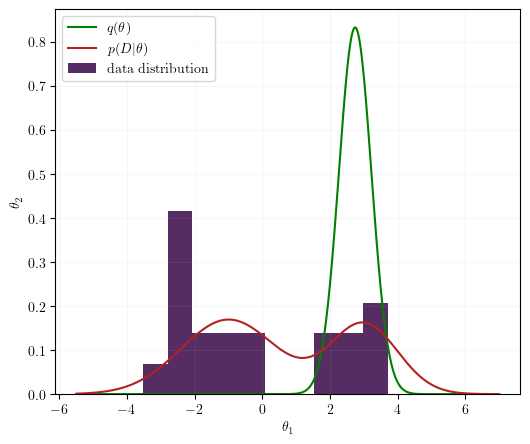

In [308]:
x = np.linspace(-5.5, 7, 1000)

plt.figure(figsize=(6,5))
plt.plot(x, Normal(q_new_["loc"].detach().squeeze().numpy(), q_new_["var"].detach().squeeze().numpy(), x, 1),
         label=r"$q(\theta)$", color='green')
#plt.axvline(q_new_["loc"].detach().squeeze().numpy(), color ="grey", label = "mean", alpha=.75)
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, w, mean_1d, var_1d, mean2_1d, var2_1d), color="firebrick", label=r"$p(D|\theta)$")
plt.hist(x_1d, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

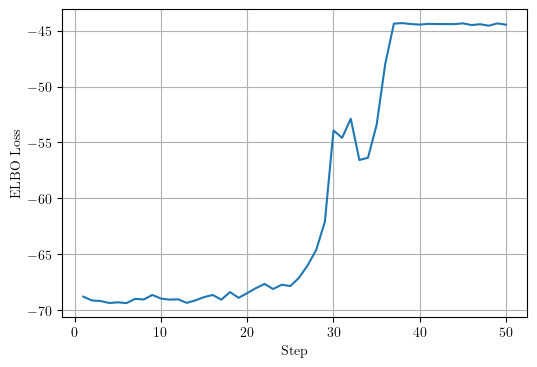

In [289]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_["Epochs"]):
    running_total = 0.
    for j in range((i* parameters_["N"]),((i+1)* parameters_["N"])):
         running_total += q_new_["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
plot_training(global_metrics["elbos"])

### PVI Two Dimensional Example
#### Initializing parameters, q_global and clients

In [48]:
parameters = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([2.]),
    "b": torch.tensor([100.]),
    "D": 2,
    "N": 20,
    "Epochs": 100,
    "Divergence": "KLD",
    "lr": 0.005,
    "samples": 50,
    "optim_epochs": 30
}

loc = torch.tensor([0.,0.])
variance_param = torch.tensor([100.])

q_global = {
    "loc": torch.nn.Parameter(loc),
    "var": torch.nn.Parameter(variance_param),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients = []
for i in range(parameters["N"]):
    clients.append({
        "client_idx": i,
        "x_n": torch.tensor([[x_[i], y_[i]]]),
        "mean": torch.tensor([0., 0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([1.]),
        "noise_m": torch.tensor([0., 0.]),
        "noise_v": parameters["a"],
        "spherical": True,
        "require_s_n": False
    })

In [49]:
q_new, clients_new = PartitionedVariationalInference(q_global, clients, parameters)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([0.1181, 0.1669], requires_grad=True) 
 var:  Parameter containing:
tensor([97.7016], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([0.1406, 0.1509], requires_grad=True) 
 var:  Parameter containing:
tensor([95.2965], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([0.0979, 0.1237], requires_grad=True) 
 var:  Parameter containing:
tensor([92.9038], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([0.0847, 0.2028], requires_grad=True) 
 var:  Parameter containing:
tensor([90.6211], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([0.0856, 0.2366], requires_grad=True) 
 var:  Parameter

New global q: 
 loc:  Parameter containing:
tensor([0.4861, 1.1469], requires_grad=True) 
 var:  Parameter containing:
tensor([15.6709], requires_grad=True)
Iteration 39:
New global q: 
 loc:  Parameter containing:
tensor([0.4713, 1.2774], requires_grad=True) 
 var:  Parameter containing:
tensor([13.6751], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Parameter containing:
tensor([0.5198, 1.3545], requires_grad=True) 
 var:  Parameter containing:
tensor([12.0927], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([0.5927, 1.4852], requires_grad=True) 
 var:  Parameter containing:
tensor([10.5996], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([0.6214, 1.4433], requires_grad=True) 
 var:  Parameter containing:
tensor([9.3102], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([0.7531, 1.6251], requires_grad=True) 
 var:  Parameter containing:
tensor([8.0833], requires_g

New global q: 
 loc:  Parameter containing:
tensor([2.6657, 2.6453], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2444], requires_grad=True)
Iteration 78:
New global q: 
 loc:  Parameter containing:
tensor([2.6284, 2.6532], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2580], requires_grad=True)
Iteration 79:
New global q: 
 loc:  Parameter containing:
tensor([2.6063, 2.6686], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2672], requires_grad=True)
Iteration 80:
New global q: 
 loc:  Parameter containing:
tensor([2.5743, 2.6555], requires_grad=True) 
 var:  Parameter containing:
tensor([0.3230], requires_grad=True)
Iteration 81:
New global q: 
 loc:  Parameter containing:
tensor([2.6531, 2.6652], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2391], requires_grad=True)
Iteration 82:
New global q: 
 loc:  Parameter containing:
tensor([2.6749, 2.6407], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2659], requires_grad=

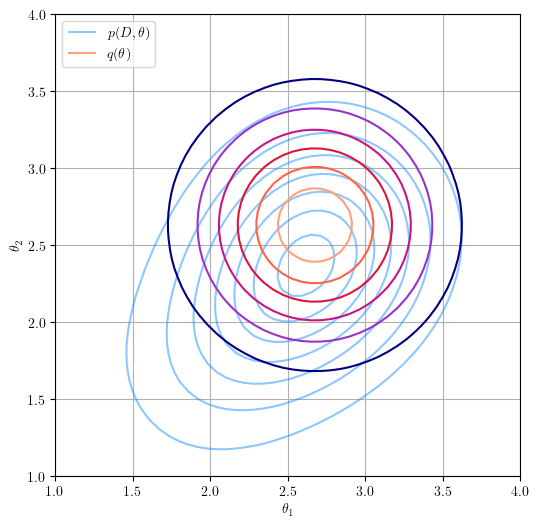

In [50]:
x = np.linspace(1,4)
y = np.linspace(1,4)
X_q, Y_q = np.meshgrid(x, y)
plt.figure(figsize=(6,6))
Z_pvi = Normal(q_new["loc"].detach().squeeze().numpy(), q_new["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters["D"])

Z_true_h = trueDistribution2D(parameters, clients_new, 1,4)

c1 = plt.contour(X_q,Y_q,Z_true_h, colors='dodgerblue', alpha=.5)

c2 = plt.contour(X_q,Y_q,Z_pvi, colors = cmap1)

#plt.scatter(x_,y_,color="firebrick")
h1,_=c1.legend_elements()
h2,_=c2.legend_elements()
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
#for i in range(len(x_)):
    #if x_[i] >= 1 and x_[i] <= 4 and y_[i] >= 1 and y_[i] <= 4:
        #plt.scatter(x_[i], y_[i], color="steelblue", alpha=.5)
        
plt.legend([h1[0],h2[0]], [r"$p(D, \theta)$", r"$q(\theta)$"], loc="upper left")
plt.grid(visible=True)
#plt.savefig("Erroneous_PVI_posterior.png")

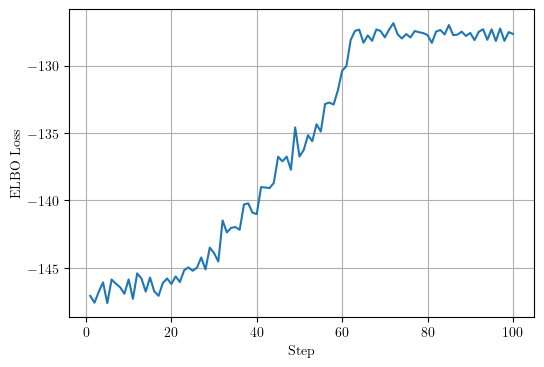

In [51]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters["Epochs"]):
    running_total = 0.
    for j in range((i* parameters["N"]),((i+1)* parameters["N"])):
         running_total += q_new["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

# Comparing EP Results with PVI Results
## One Dimensional Example

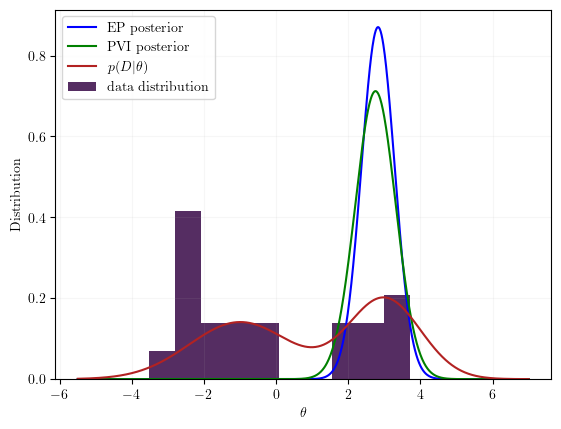

In [52]:
x = np.linspace(-5.5, 7, 1000)

plt.plot(x, Normal(q_new_ep_["mean"], q_new_ep_["variance"], x, 1),
         label="EP posterior", color='blue')
#plt.axvline(q_new_ep_["mean"].numpy(), color ="grey", label = "mean EP", alpha=.5)

plt.plot(x, Normal(q_new_["loc"].detach().squeeze().numpy(), q_new_["var"].detach().squeeze().numpy(), x, 1),
         label="PVI posterior", color='green')
#plt.axvline(q_new_["loc"].detach().squeeze().numpy(), color ="black", label = "mean PVI", alpha=.5)

#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, w, mean_1d, var_1d, mean2_1d, var2_1d), color="firebrick", label=r"$p(D|\theta)$")
plt.hist(x_1d, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel(r"$\theta$")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)
#plt.savefig('PVI_and_EP_diff.png')

## Two Dimensional Example

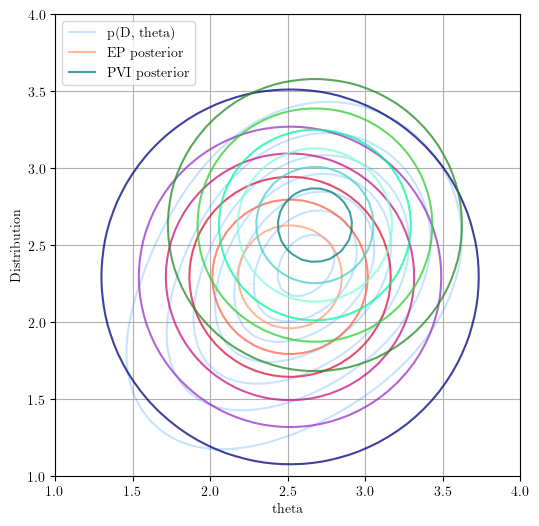

In [53]:
x = np.linspace(1,4)
y = np.linspace(1,4)
X_q, Y_q = np.meshgrid(x, y)
plt.figure(figsize=(6,6))
Z_pvi = Normal(q_new["loc"].detach().squeeze().numpy(), q_new["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters["D"])

Z_true_h = trueDistribution2D(parameters, clients, 1., 4)

Z_ep = Normal(q_new_ep["mean"], q_new_ep["variance"], [X_q, Y_q], parameters["D"])


c1 = plt.contour(X_q,Y_q,Z_true_h, colors='dodgerblue', alpha=.25)
c2 = plt.contour(X_q,Y_q,Z_ep, colors=cmap1, alpha=.75)

c3 = plt.contour(X_q,Y_q,Z_pvi, colors = cmap2, alpha =.75)

h1,_=c1.legend_elements()
h2,_=c2.legend_elements()
h3,_=c3.legend_elements()
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend([h1[0],h2[0], h3[0]], ["p(D, theta)", "EP posterior", "PVI posterior"], loc="upper left")
plt.grid(visible=True)

# Eperiments for Section 3.7
## Section 3.7.1 Unimodal Gaussian Mixtures
### 1-D case

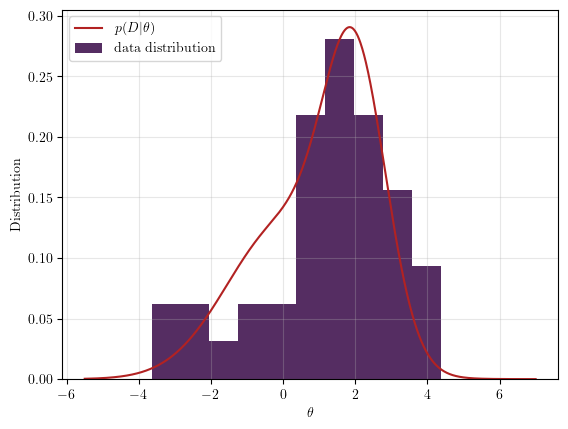

In [209]:
#Generate Data
mean_1_uni = torch.tensor([2.])
var_1_uni = torch.tensor([1.])
mean_2_uni = torch.tensor([0.])
var_2_uni = torch.tensor([2.])
w = 0.5

samples_uni = Gaussian.HeterogenousSampleMix([mean_1_uni,mean_2_uni], [var_1_uni,var_2_uni], torch.tensor([w,w]), 40)
true_samples = samples_uni[0]
noise_samples = samples_uni[1]
samples = torch.cat((true_samples, noise_samples))
samp = samples.numpy()
client_data = homogeneous_split(samples,40)

x = np.linspace(-5.5, 7, 1000)

plt.plot(x, Mix(x, 0.5, 2., 1, 0., 2), color="firebrick", label=r"$p(D|\theta)$")
plt.hist(samp, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel(r"$\theta$")
plt.ylabel("Distribution")
plt.legend(loc="upper left")

plt.grid(visible=True, alpha=.3)
#plt.savefig("unimodal_mix_1d.png")
plt.show()

In [210]:
# EP implementation
parameters_ep_uni = {
    "w": 0.5,
    "a": 2.,
    "b": 10.,
    "D": 1,
    "N": 40,
    "Epochs": 10
}

q_global_ep_uni = {
    "mean": 0.,
    "variance": parameters_ep_uni["b"]
}

clients_ep_uni = []
for i in range(40):
    clients_ep_uni.append({
        "client_idx": i,
        "x_n": float(client_data[0][0][0]),
        "mean": 0.,
        "variance": np.inf,
        "variance_inverse": 0.,
        "normaliser": 1.,
        "iteration": 0
    })
q_new_ep_uni, clients_new_ep_uni = ExpectationPropagation(clients_ep_uni, q_global_ep_uni, parameters_ep_uni)

# PVI implementation
parameters_uni = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([2.]),
    "b": torch.tensor([10.]),
    "D": 1,
    "N": 40,
    "Epochs": 50,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

q_global_uni = {
    "loc": torch.nn.Parameter(torch.tensor([0.])),
    "var": torch.nn.Parameter(parameters_uni["b"]),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_uni = []
for i in range(40):
    clients_uni.append({
        "client_idx": i,
        "x_n": client_data[i],
        "mean": torch.tensor([0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": var_1_uni,
        "noise_m": torch.tensor([0.]),
        "noise_v": parameters_uni["a"],
        "spherical": True,
        "require_s_n": False
    })
    
q_new_1d, clients_new_1d = PartitionedVariationalInference(q_global_uni, clients_uni, parameters_uni, is_1d=True)

# VI implmentation
parameters_uni = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([2.]),
    "b": torch.tensor([10.]),
    "D": 1,
    "N": 40,
    "Epochs": 50,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

q_global_uni_vi = {
    "loc": torch.nn.Parameter(torch.tensor([0.])),
    "var": torch.nn.Parameter(parameters_uni["b"]),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_uni_vi = []
clients_uni_vi.append({
    "client_idx": i,
    "x_n": samples,
    "mean": torch.tensor([0.]),
    "variance": torch.tensor([np.inf]),
    "variance_inverse": torch.tensor([0.]),
    "normaliser": torch.tensor(1.),
    "iteration": 0,
    "true_v": var_1_uni,
    "noise_m": torch.tensor([0.]),
    "noise_v": parameters_uni["a"],
    "spherical": True,
    "require_s_n": False
})

q_new_1d_vi, clients_new_1d_vi = PartitionedVariationalInference(q_global_uni_vi, clients_uni_vi, parameters_uni, is_1d=True)

Iteration 1:
New global q:  {'mean': array([2.51231486]), 'variance': array([0.03089265])}
Iteration 2:
New global q:  {'mean': array([2.51059352]), 'variance': array([0.02870319])}
Iteration 3:
New global q:  {'mean': array([2.51059373]), 'variance': array([0.02870237])}
Iteration 4:
New global q:  {'mean': array([2.51059373]), 'variance': array([0.02870237])}
Iteration 5:
New global q:  {'mean': array([2.51059373]), 'variance': array([0.02870237])}
Iteration 6:
New global q:  {'mean': array([2.51059373]), 'variance': array([0.02870237])}
Iteration 7:
New global q:  {'mean': array([2.51059373]), 'variance': array([0.02870237])}
Iteration 8:
New global q:  {'mean': array([2.51059373]), 'variance': array([0.02870237])}
Iteration 9:
New global q:  {'mean': array([2.51059373]), 'variance': array([0.02870237])}
Iteration 10:
New global q:  {'mean': array([2.51059373]), 'variance': array([0.02870237])}
Starting global q:  {'loc': Parameter containing:
tensor([0.], requires_grad=True), 'var'

New global q: 
 loc:  Parameter containing:
tensor([2.4575], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2280], requires_grad=True)
Iteration 35:
New global q: 
 loc:  Parameter containing:
tensor([2.4427], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1625], requires_grad=True)
Iteration 36:
New global q: 
 loc:  Parameter containing:
tensor([2.4312], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1852], requires_grad=True)
Iteration 37:
New global q: 
 loc:  Parameter containing:
tensor([2.4538], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2066], requires_grad=True)
Iteration 38:
New global q: 
 loc:  Parameter containing:
tensor([2.4253], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1958], requires_grad=True)
Iteration 39:
New global q: 
 loc:  Parameter containing:
tensor([2.4295], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2232], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Parame

New global q: 
 loc:  Parameter containing:
tensor([1.6343], requires_grad=True) 
 var:  Parameter containing:
tensor([3.2382], requires_grad=True)
Iteration 24:
New global q: 
 loc:  Parameter containing:
tensor([1.8068], requires_grad=True) 
 var:  Parameter containing:
tensor([2.9358], requires_grad=True)
Iteration 25:
New global q: 
 loc:  Parameter containing:
tensor([1.9174], requires_grad=True) 
 var:  Parameter containing:
tensor([2.6344], requires_grad=True)
Iteration 26:
New global q: 
 loc:  Parameter containing:
tensor([2.0721], requires_grad=True) 
 var:  Parameter containing:
tensor([2.3300], requires_grad=True)
Iteration 27:
New global q: 
 loc:  Parameter containing:
tensor([2.1839], requires_grad=True) 
 var:  Parameter containing:
tensor([2.0302], requires_grad=True)
Iteration 28:
New global q: 
 loc:  Parameter containing:
tensor([2.2355], requires_grad=True) 
 var:  Parameter containing:
tensor([1.7321], requires_grad=True)
Iteration 29:
New global q: 
 loc:  Parame

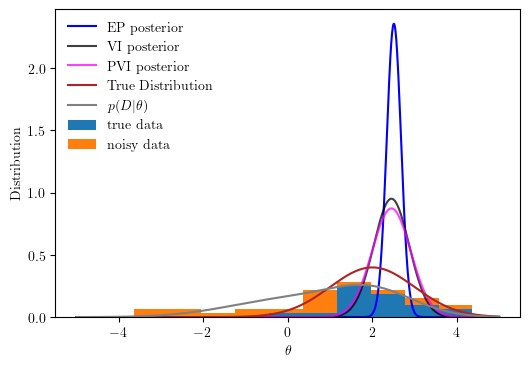

In [507]:
x = np.linspace(-5, 5, 1000)
plt.figure(figsize=(6,4))
plt.plot(x, Normal(q_new_ep_uni["mean"], q_new_ep_uni["variance"], x, 1),
         label="EP posterior", color='blue')

plt.plot(x, Normal(q_new_1d_vi["loc"].detach().squeeze().numpy(), q_new_1d_vi["var"].detach().squeeze().numpy(), x, 1),
         label="VI posterior", color='black', alpha=.75)
plt.plot(x, Normal(q_new_1d["loc"].detach().squeeze().numpy(), q_new_1d["var"].detach().squeeze().numpy(), x, 1),
         label="PVI posterior", color='magenta', alpha=.75)

plt.plot(x, Normal(2, 1., x, 1), label="True Distribution", color='firebrick')
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, 0.5, 2., 1, 0., 2), color="grey", label=r"$p(D|\theta)$")
d = [true_samples.T[0].numpy(), noise_samples.T[0].numpy()]
plt.hist(d, density=True, bins=10, label=["true data", "noisy data"], histtype='bar', stacked=True)
#plt.hist(noise_samples.numpy(), density=True, bins=10, label="noisy data", color="black")

plt.xlabel(r"$\theta$")
plt.ylabel("Distribution")
plt.legend(loc="upper left", frameon=False)
#plt.grid(visible=True, alpha=.1)
plt.savefig('unimodal_1d.pgf', pad_inches=0)
plt.show()

### 2-D case

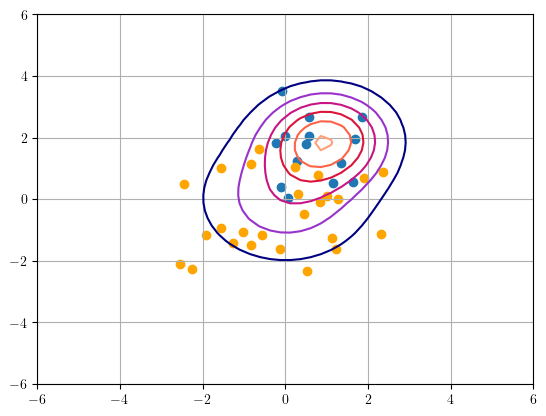

In [387]:
#Defining the model and sampling data points

mean_1_uni_2d = torch.tensor([1.,2.])
var_1_uni_2d = torch.eye(2)
mean_2_uni_2d = torch.tensor([0.,0.])
var_2_uni_2d = 2*torch.eye(2)

samples_uni_2d = Gaussian.HeterogenousSampleMix([mean_1_uni_2d,mean_2_uni_2d], [var_1_uni_2d,var_2_uni_2d], torch.tensor([.5,.5]), 40)
true_samples_2d = samples_uni_2d[0]
noise_samples_2d = samples_uni_2d[1]
samples_2d = torch.cat((true_samples_2d, noise_samples_2d))
samp_2d = samples_2d.numpy()
client_data_2d = homogeneous_split(samples_2d,40)
x = y = np.linspace(-6,6)
X_, Y_ = np.meshgrid(x, y)

Z_ = Mixture([X_, Y_], 0.5, [1.,2.], 1., [0.,0.], 2., 2)

plt.contour(X_,Y_,Z_, colors=cmap1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
#plt.scatter(samp_2d[:,0], samp_2d[:,1], c="steelblue", alpha=.8)
plt.scatter(true_samples_2d[:,0], true_samples_2d[:,1], label="true data")
plt.scatter(noise_samples_2d[:,0], noise_samples_2d[:,1], label="noisy data", color='orange')
plt.grid(visible=True)

In [389]:
# EP implementation
parameters_ep_uni_2d = {
    "w": 0.5,
    "a": 2,
    "b": 10,
    "D": 2,
    "N": 40,
    "Epochs": 10
}

q_global_ep_uni_2d = {
    "mean": np.array([0.,0.]),
    "variance": parameters_ep_uni_2d["b"]
}

clients_ep_uni_2d = []

for i in range(40):
    clients_ep_uni_2d.append({
        "client_idx": i,
        "x_n": client_data_2d[i][0].numpy(),
        "mean": np.array([0.,0.]),
        "variance": np.inf,
        "variance_inverse": 0.,
        "normaliser": 1.,
        "iteration": 0
    })

q_new_ep_uni_2d, clients_new_ep_uni_2d = ExpectationPropagation(clients_ep_uni_2d, q_global_ep_uni_2d, parameters_ep_uni_2d)

# PVI implementation
parameters_uni_2d = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([2.]),
    "b": torch.tensor([10.]),
    "D": 2,
    "N": 40,
    "Epochs": 100,
    "Divergence": "KLD",
    "lr": 0.005,
    "samples": 50,
    "optim_epochs": 30
}

loc = torch.tensor([0.,0.])
variance_param = torch.tensor([10.])

q_global_uni_2d = {
    "loc": torch.nn.Parameter(loc),
    "var": torch.nn.Parameter(variance_param),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_uni_2d = []
for i in range(parameters["N"]):
    clients_uni_2d.append({
        "client_idx": i,
        "x_n": client_data_2d[i],
        "mean": torch.tensor([0., 0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([1.]),
        "noise_m": torch.tensor([0., 0.]),
        "noise_v": parameters_uni_2d["a"],
        "spherical": True,
        "require_s_n": False
    })
    
q_new_uni_2d, clients_new_uni_2d = PartitionedVariationalInference(q_global_uni_2d, clients_uni_2d, parameters_uni_2d)

# VI implementation
parameters_uni_2d = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([2.]),
    "b": torch.tensor([10.]),
    "D": 2,
    "N": 40,
    "Epochs": 100,
    "Divergence": "KLD",
    "lr": 0.005,
    "samples": 50,
    "optim_epochs": 40
}

loc = torch.tensor([0.,0.])
variance_param = torch.tensor([10.])

q_global_uni_2d_vi = {
    "loc": torch.nn.Parameter(loc),
    "var": torch.nn.Parameter(variance_param),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_uni_2d_vi = []
clients_uni_2d_vi.append({
    "client_idx": i,
    "x_n": samples_2d,
    "mean": torch.tensor([0., 0.]),
    "variance": torch.tensor([np.inf]),
    "variance_inverse": torch.tensor([0.]),
    "normaliser": torch.tensor(1.),
    "iteration": 0,
    "true_v": torch.tensor([1.]),
    "noise_m": torch.tensor([0., 0.]),
    "noise_v": parameters_uni_2d["a"],
    "spherical": True,
    "require_s_n": False
})
    
q_new_uni_2d_vi, clients_new_uni_2d_vi = PartitionedVariationalInference(q_global_uni_2d_vi, clients_uni_2d_vi, parameters_uni_2d)

Iteration 1:
New global q:  {'mean': array([0.52176953, 1.02074284]), 'variance': 0.16527768587234679}
Iteration 2:
New global q:  {'mean': array([0.6520598 , 1.05896601]), 'variance': 0.12089701349839833}
Iteration 3:
New global q:  {'mean': array([0.65470538, 1.08743971]), 'variance': 0.11926858706560821}
Iteration 4:
New global q:  {'mean': array([0.655021 , 1.0874076]), 'variance': 0.11928935798931897}
Iteration 5:
New global q:  {'mean': array([0.65494471, 1.0873574 ]), 'variance': 0.11932048992356091}
Iteration 6:
New global q:  {'mean': array([0.65494538, 1.08735656]), 'variance': 0.1193244973103802}
Iteration 7:
New global q:  {'mean': array([0.654945  , 1.08735598]), 'variance': 0.11932452887024896}
Iteration 8:
New global q:  {'mean': array([0.65494497, 1.08735596]), 'variance': 0.11932453499738364}
Iteration 9:
New global q:  {'mean': array([0.65494497, 1.08735596]), 'variance': 0.11932453451283441}
Iteration 10:
New global q:  {'mean': array([0.65494497, 1.08735596]), 'vari

New global q: 
 loc:  Parameter containing:
tensor([0.7718, 0.8717], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2135], requires_grad=True)
Iteration 33:
New global q: 
 loc:  Parameter containing:
tensor([0.7778, 0.8530], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2464], requires_grad=True)
Iteration 34:
New global q: 
 loc:  Parameter containing:
tensor([0.7130, 0.8550], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2240], requires_grad=True)
Iteration 35:
New global q: 
 loc:  Parameter containing:
tensor([0.7615, 0.8761], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2348], requires_grad=True)
Iteration 36:
New global q: 
 loc:  Parameter containing:
tensor([0.7550, 0.8392], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2339], requires_grad=True)
Iteration 37:
New global q: 
 loc:  Parameter containing:
tensor([0.7573, 0.8283], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2246], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([0.7729, 0.8375], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2303], requires_grad=True)
Iteration 72:
New global q: 
 loc:  Parameter containing:
tensor([0.7592, 0.8946], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2231], requires_grad=True)
Iteration 73:
New global q: 
 loc:  Parameter containing:
tensor([0.7611, 0.8549], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2177], requires_grad=True)
Iteration 74:
New global q: 
 loc:  Parameter containing:
tensor([0.7817, 0.8523], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2069], requires_grad=True)
Iteration 75:
New global q: 
 loc:  Parameter containing:
tensor([0.7793, 0.8280], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2673], requires_grad=True)
Iteration 76:
New global q: 
 loc:  Parameter containing:
tensor([0.7693, 0.8714], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2345], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([0.1751, 0.3597], requires_grad=True) 
 var:  Parameter containing:
tensor([8.2022], requires_grad=True)
Iteration 10:
New global q: 
 loc:  Parameter containing:
tensor([0.1607, 0.3759], requires_grad=True) 
 var:  Parameter containing:
tensor([8.0021], requires_grad=True)
Iteration 11:
New global q: 
 loc:  Parameter containing:
tensor([0.0872, 0.4026], requires_grad=True) 
 var:  Parameter containing:
tensor([7.8006], requires_grad=True)
Iteration 12:
New global q: 
 loc:  Parameter containing:
tensor([0.0209, 0.4145], requires_grad=True) 
 var:  Parameter containing:
tensor([7.6014], requires_grad=True)
Iteration 13:
New global q: 
 loc:  Parameter containing:
tensor([0.0603, 0.4232], requires_grad=True) 
 var:  Parameter containing:
tensor([7.4001], requires_grad=True)
Iteration 14:
New global q: 
 loc:  Parameter containing:
tensor([0.1487, 0.4195], requires_grad=True) 
 var:  Parameter containing:
tensor([7.2002], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([0.6152, 0.9693], requires_grad=True) 
 var:  Parameter containing:
tensor([0.4009], requires_grad=True)
Iteration 49:
New global q: 
 loc:  Parameter containing:
tensor([0.6365, 1.0084], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2077], requires_grad=True)
Iteration 50:
New global q: 
 loc:  Parameter containing:
tensor([0.6600, 1.0925], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1094], requires_grad=True)
Iteration 51:
New global q: 
 loc:  Parameter containing:
tensor([0.6560, 1.0773], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1149], requires_grad=True)
Iteration 52:
New global q: 
 loc:  Parameter containing:
tensor([0.6706, 1.0941], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1185], requires_grad=True)
Iteration 53:
New global q: 
 loc:  Parameter containing:
tensor([0.6479, 1.0918], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1130], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([0.6450, 1.0952], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1059], requires_grad=True)
Iteration 88:
New global q: 
 loc:  Parameter containing:
tensor([0.6342, 1.0997], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1221], requires_grad=True)
Iteration 89:
New global q: 
 loc:  Parameter containing:
tensor([0.6558, 1.0810], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1120], requires_grad=True)
Iteration 90:
New global q: 
 loc:  Parameter containing:
tensor([0.6466, 1.0710], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1123], requires_grad=True)
Iteration 91:
New global q: 
 loc:  Parameter containing:
tensor([0.6687, 1.1082], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1137], requires_grad=True)
Iteration 92:
New global q: 
 loc:  Parameter containing:
tensor([0.6652, 1.0895], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1108], requires_grad=

/Users/terjemildner/anaconda3/lib/python3.11/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


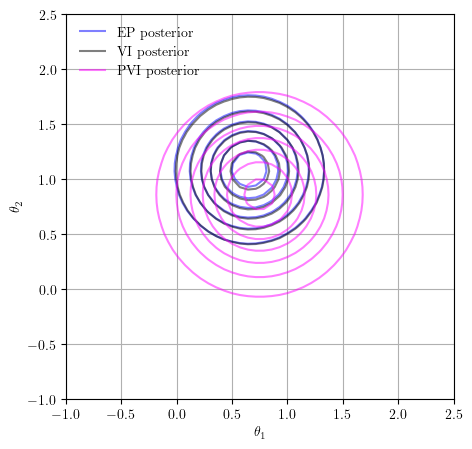

In [392]:
x = np.linspace(-1,2.5)
y = np.linspace(-1,2.5)
X_q, Y_q = np.meshgrid(x, y)
plt.figure(figsize=(5,5))



Z_ep = Normal(q_new_ep_uni_2d["mean"], q_new_ep_uni_2d["variance"], [X_q, Y_q], parameters["D"])
Z_pvi = Normal(q_new_uni_2d["loc"].detach().squeeze().numpy(), q_new_uni_2d["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters["D"])

Z_vi = Normal(q_new_uni_2d_vi["loc"].detach().squeeze().numpy(), q_new_uni_2d_vi["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters["D"])

Z_true = Normal(mean_1_uni_2d.numpy(), 2, [X_q, Y_q], parameters["D"])
Z_ = Mixture([X_, Y_], 0.5, [2.,2.], 1., [0.,0.], 5., 2)
c1 = plt.contour(X_q,Y_q,Z_ep, colors='blue', alpha=.5)
c2 = plt.contour(X_q,Y_q,Z_vi, colors = "black", alpha=.5)
c3 = plt.contour(X_q,Y_q,Z_pvi, colors = "magenta", alpha=.5)
#c4 = plt.contour(X_q,Y_q,Z_true, colors = "firebrick", alpha=.5)
#c5 = plt.contour(X_q,Y_q,Z_, colors = "grey", alpha=.5)
#c4=plt.scatter(true_samples_2d[:,0], true_samples_2d[:,1], label="true data", alpha=.5)
#c5=plt.scatter(noise_samples_2d[:,0], noise_samples_2d[:,1], label="noisy data", color='orange', alpha=.5)

h1,_=c1.legend_elements()
h2,_=c2.legend_elements()
h3,_=c3.legend_elements()
h4,_=c4.legend_elements()
h5,_=c5.legend_elements()
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")

plt.legend([h1[0],h2[0], h3[0]], [r"EP posterior", r"VI posterior", "PVI posterior"], loc="upper left", frameon=False)

#plt.legend([h1[0],h2[0], h3[0], h4[0], h5[0]], [r"EP posterior", r"VI posterior", "PVI posterior", "True Distribution", r"$p(D|\theta)$"], loc="upper left", frameon=False)
plt.grid(visible=True)
#plt.grid(visible=True, alpha=.1)
plt.savefig('unimodal_2d.pgf', pad_inches=0)
plt.show()

## Section 3.7.2 Bimodal
### 1-D

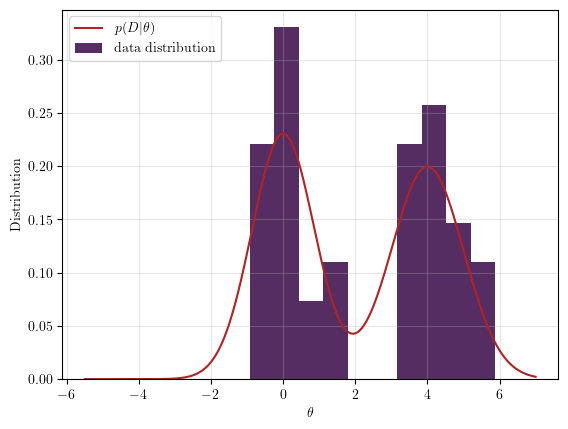

In [37]:
#Generate Data
mean_1_bi = torch.tensor([4.])
var_1_bi = torch.tensor([1.])
mean_2_bi = torch.tensor([0.])
var_2_bi = torch.tensor([.75])
w = 0.5

samples_bi = Gaussian.HeterogenousSampleMix([mean_1_bi,mean_2_bi], [var_1_bi,var_2_bi], torch.tensor([w,w]), 40)
true_samples_bi = samples_bi[0]
noise_samples_bi = samples_bi[1]
samples_bi = torch.cat((true_samples_bi, noise_samples_bi))
samp_bi = samples_bi.numpy()
client_data_bi = homogeneous_split(samples_bi,40)

x = np.linspace(-5.5, 7, 1000)

plt.plot(x, Mix(x, 0.5, 4., 1, 0., .75), color="firebrick", label=r"$p(D|\theta)$")
plt.hist(samp_bi, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel(r"$\theta$")
plt.ylabel("Distribution")
plt.legend(loc="upper left")

plt.grid(visible=True, alpha=.3)
#plt.savefig("unimodal_mix_1d.png")
plt.show()

In [213]:
# EP implementation
parameters_ep_bi = {
    "w": 0.5,
    "a": .75,
    "b": 10.,
    "D": 1,
    "N": 40,
    "Epochs": 10
}

q_global_ep_bi = {
    "mean": 0.,
    "variance": parameters_ep_bi["b"]
}

clients_ep_bi = []
for i in range(40):
    clients_ep_bi.append({
        "client_idx": i,
        "x_n": float(client_data_bi[0][0][0]),
        "mean": 0.,
        "variance": np.inf,
        "variance_inverse": 0.,
        "normaliser": 1.,
        "iteration": 0
    })
q_new_ep_bi, clients_new_ep_bi = ExpectationPropagation(clients_ep_bi, q_global_ep_bi, parameters_ep_bi)

# PVI implementation
parameters_bi = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([.75]),
    "b": torch.tensor([10.]),
    "D": 1,
    "N": 40,
    "Epochs": 50,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

q_global_bi = {
    "loc": torch.nn.Parameter(torch.tensor([0.])),
    "var": torch.nn.Parameter(parameters_bi["b"]),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_bi = []
for i in range(40):
    clients_bi.append({
        "client_idx": i,
        "x_n": client_data_bi[i],
        "mean": torch.tensor([0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": var_1_bi,
        "noise_m": torch.tensor([0.]),
        "noise_v": parameters_bi["a"],
        "spherical": True,
        "require_s_n": False
    })
    
q_new_1d_bi, clients_new_1d_bi = PartitionedVariationalInference(q_global_bi, clients_bi, parameters_bi, is_1d=True)

# VI implmentation
parameters_bi = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([.75]),
    "b": torch.tensor([10.]),
    "D": 1,
    "N": 40,
    "Epochs": 50,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

q_global_bi_vi = {
    "loc": torch.nn.Parameter(torch.tensor([0.])),
    "var": torch.nn.Parameter(parameters_bi["b"]),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_bi_vi = []
clients_bi_vi.append({
    "client_idx": i,
    "x_n": samples_bi,
    "mean": torch.tensor([0.]),
    "variance": torch.tensor([np.inf]),
    "variance_inverse": torch.tensor([0.]),
    "normaliser": torch.tensor(1.),
    "iteration": 0,
    "true_v": var_1_bi,
    "noise_m": torch.tensor([0.]),
    "noise_v": parameters_bi["a"],
    "spherical": True,
    "require_s_n": False
})

q_new_1d_vi_bi, clients_new_1d_vi_bi = PartitionedVariationalInference(q_global_bi_vi, clients_bi_vi, parameters_bi, is_1d=True)

Iteration 1:
New global q:  {'mean': array([3.09008249]), 'variance': array([0.02509982])}
Iteration 2:
New global q:  {'mean': array([3.08956027]), 'variance': array([0.02498746])}
Iteration 3:
New global q:  {'mean': array([3.08956027]), 'variance': array([0.02498746])}
Iteration 4:
New global q:  {'mean': array([3.08956027]), 'variance': array([0.02498746])}
Iteration 5:
New global q:  {'mean': array([3.08956027]), 'variance': array([0.02498746])}
Iteration 6:
New global q:  {'mean': array([3.08956027]), 'variance': array([0.02498746])}
Iteration 7:
New global q:  {'mean': array([3.08956027]), 'variance': array([0.02498746])}
Iteration 8:
New global q:  {'mean': array([3.08956027]), 'variance': array([0.02498746])}
Iteration 9:
New global q:  {'mean': array([3.08956027]), 'variance': array([0.02498746])}
Iteration 10:
New global q:  {'mean': array([3.08956027]), 'variance': array([0.02498746])}
Starting global q:  {'loc': Parameter containing:
tensor([0.], requires_grad=True), 'var'

New global q: 
 loc:  Parameter containing:
tensor([3.9434], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1352], requires_grad=True)
Iteration 35:
New global q: 
 loc:  Parameter containing:
tensor([3.9436], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1432], requires_grad=True)
Iteration 36:
New global q: 
 loc:  Parameter containing:
tensor([3.9268], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1308], requires_grad=True)
Iteration 37:
New global q: 
 loc:  Parameter containing:
tensor([3.9286], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1793], requires_grad=True)
Iteration 38:
New global q: 
 loc:  Parameter containing:
tensor([3.9443], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1409], requires_grad=True)
Iteration 39:
New global q: 
 loc:  Parameter containing:
tensor([3.9430], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1335], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Parame

New global q: 
 loc:  Parameter containing:
tensor([3.9090], requires_grad=True) 
 var:  Parameter containing:
tensor([3.1955], requires_grad=True)
Iteration 24:
New global q: 
 loc:  Parameter containing:
tensor([3.9836], requires_grad=True) 
 var:  Parameter containing:
tensor([2.8949], requires_grad=True)
Iteration 25:
New global q: 
 loc:  Parameter containing:
tensor([4.0344], requires_grad=True) 
 var:  Parameter containing:
tensor([2.5960], requires_grad=True)
Iteration 26:
New global q: 
 loc:  Parameter containing:
tensor([4.1538], requires_grad=True) 
 var:  Parameter containing:
tensor([2.2941], requires_grad=True)
Iteration 27:
New global q: 
 loc:  Parameter containing:
tensor([4.0631], requires_grad=True) 
 var:  Parameter containing:
tensor([1.9956], requires_grad=True)
Iteration 28:
New global q: 
 loc:  Parameter containing:
tensor([4.0691], requires_grad=True) 
 var:  Parameter containing:
tensor([1.7012], requires_grad=True)
Iteration 29:
New global q: 
 loc:  Parame

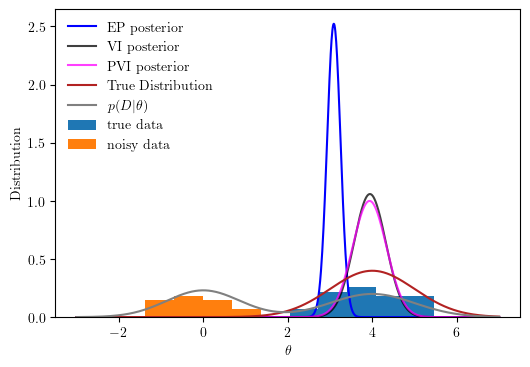

In [489]:
x = np.linspace(-3, 7, 1000)
plt.figure(figsize=(6,4))
plt.plot(x, Normal(q_new_ep_bi["mean"], q_new_ep_bi["variance"], x, 1),
         label="EP posterior", color='blue')

plt.plot(x, Normal(q_new_1d_vi_bi["loc"].detach().squeeze().numpy(), q_new_1d_vi_bi["var"].detach().squeeze().numpy(), x, 1),
         label="VI posterior", color='black', alpha=.75)
plt.plot(x, Normal(q_new_1d_bi["loc"].detach().squeeze().numpy(), q_new_1d_bi["var"].detach().squeeze().numpy(), x, 1),
         label="PVI posterior", color='magenta', alpha=.75)

plt.plot(x, Normal(4, 1., x, 1), label="True Distribution", color='firebrick')
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, 0.5, 4., 1, 0., .75), color="grey", label=r"$p(D|\theta)$")
d = [true_samples_bi.T[0].numpy(), noise_samples_bi.T[0].numpy()]
plt.hist(d, density=True, bins=10, label=["true data", "noisy data"], histtype='bar', stacked=True)
#plt.hist(noise_samples.numpy(), density=True, bins=10, label="noisy data", color="black")

plt.xlabel(r"$\theta$")
plt.ylabel("Distribution")
plt.legend(loc="upper left", frameon=False)
#plt.grid(visible=True, alpha=.1)
plt.savefig('bimodal_1d.pgf', pad_inches=0)
plt.show()

### 2-D case

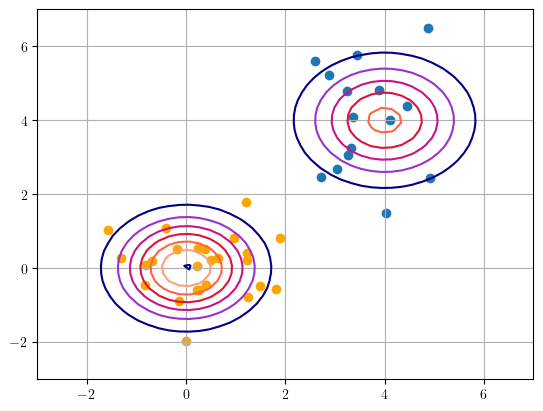

In [243]:
#Defining the model and sampling data points

mean_1_bi_2d = torch.tensor([4.,4.])
var_1_bi_2d = torch.eye(2)
mean_2_bi_2d = torch.tensor([0.,0.])
var_2_bi_2d = .75*torch.eye(2)

samples_bi_2d = Gaussian.HeterogenousSampleMix([mean_1_bi_2d,mean_2_bi_2d], [var_1_bi_2d,var_2_bi_2d], torch.tensor([.5,.5]), 40)
true_samples_2d_bi = samples_bi_2d[0]
noise_samples_2d_bi = samples_bi_2d[1]
samples_2d_bi = torch.cat((true_samples_2d_bi, noise_samples_2d_bi))
samp_2d_bi = samples_2d_bi.numpy()
client_data_2d_bi = homogeneous_split(samples_2d_bi,40)
x = y = np.linspace(-3,7)
X_, Y_ = np.meshgrid(x, y)

Z_ = Mixture([X_, Y_], 0.5, [4.,4.], 1., [0.,0.], .75, 2)

plt.contour(X_,Y_,Z_, colors=cmap1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
#plt.scatter(samp_2d[:,0], samp_2d[:,1], c="steelblue", alpha=.8)
plt.scatter(true_samples_2d_bi[:,0], true_samples_2d_bi[:,1], label="true data")
plt.scatter(noise_samples_2d_bi[:,0], noise_samples_2d_bi[:,1], label="noisy data", color='orange')
plt.grid(visible=True)

In [244]:
# EP implementation
parameters_ep_bi_2d = {
    "w": 0.5,
    "a": .75,
    "b": 10,
    "D": 2,
    "N": 40,
    "Epochs": 10
}

q_global_ep_bi_2d = {
    "mean": np.array([0.,0.]),
    "variance": parameters_ep_bi_2d["b"]
}

clients_ep_bi_2d = []

for i in range(40):
    clients_ep_bi_2d.append({
        "client_idx": i,
        "x_n": client_data_2d_bi[i][0].numpy(),
        "mean": np.array([0.,0.]),
        "variance": np.inf,
        "variance_inverse": 0.,
        "normaliser": 1.,
        "iteration": 0
    })

q_new_ep_bi_2d, clients_new_ep_bi_2d = ExpectationPropagation(clients_ep_bi_2d, q_global_ep_bi_2d, parameters_ep_bi_2d)

# PVI implementation
parameters_bi_2d = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([.75]),
    "b": torch.tensor([10.]),
    "D": 2,
    "N": 40,
    "Epochs": 100,
    "Divergence": "KLD",
    "lr": 0.005,
    "samples": 50,
    "optim_epochs": 30
}

loc = torch.tensor([0.,0.])
variance_param = torch.tensor([10.])

q_global_bi_2d = {
    "loc": torch.nn.Parameter(loc),
    "var": torch.nn.Parameter(variance_param),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_bi_2d = []
for i in range(parameters["N"]):
    clients_bi_2d.append({
        "client_idx": i,
        "x_n": client_data_2d_bi[i],
        "mean": torch.tensor([0., 0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([1.]),
        "noise_m": torch.tensor([0., 0.]),
        "noise_v": parameters_bi_2d["a"],
        "spherical": True,
        "require_s_n": False
    })
    
q_new_bi_2d, clients_new_bi_2d = PartitionedVariationalInference(q_global_bi_2d, clients_bi_2d, parameters_bi_2d)

# VI implementation
parameters_bi_2d = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([.75]),
    "b": torch.tensor([10.]),
    "D": 2,
    "N": 40,
    "Epochs": 100,
    "Divergence": "KLD",
    "lr": 0.005,
    "samples": 50,
    "optim_epochs": 30
}

loc = torch.tensor([0.,0.])
variance_param = torch.tensor([10.])

q_global_bi_2d_vi = {
    "loc": torch.nn.Parameter(loc),
    "var": torch.nn.Parameter(variance_param),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_bi_2d_vi = []
clients_bi_2d_vi.append({
    "client_idx": i,
    "x_n": samples_2d_bi,
    "mean": torch.tensor([0., 0.]),
    "variance": torch.tensor([np.inf]),
    "variance_inverse": torch.tensor([0.]),
    "normaliser": torch.tensor(1.),
    "iteration": 0,
    "true_v": torch.tensor([1.]),
    "noise_m": torch.tensor([0., 0.]),
    "noise_v": parameters_bi_2d["a"],
    "spherical": True,
    "require_s_n": False
})
    
q_new_bi_2d_vi, clients_new_bi_2d_vi = PartitionedVariationalInference(q_global_bi_2d_vi, clients_bi_2d_vi, parameters_bi_2d)


Iteration 1:
New global q:  {'mean': array([3.56553331, 3.98180313]), 'variance': 0.06707336844837493}
Iteration 2:
New global q:  {'mean': array([3.56799145, 3.9929076 ]), 'variance': 0.06819128835335149}
Iteration 3:
New global q:  {'mean': array([3.56800455, 3.99286808]), 'variance': 0.06819505871260474}
Iteration 4:
New global q:  {'mean': array([3.56800452, 3.99286803]), 'variance': 0.06819506512224117}
Iteration 5:
New global q:  {'mean': array([3.56800452, 3.99286803]), 'variance': 0.06819506512831129}
Iteration 6:
New global q:  {'mean': array([3.56800452, 3.99286803]), 'variance': 0.068195065128317}
Iteration 7:
New global q:  {'mean': array([3.56800452, 3.99286803]), 'variance': 0.06819506512831704}
Iteration 8:
New global q:  {'mean': array([3.56800452, 3.99286803]), 'variance': 0.06819506512831701}
Iteration 9:
New global q:  {'mean': array([3.56800452, 3.99286803]), 'variance': 0.06819506512831702}
Iteration 10:
New global q:  {'mean': array([3.56800452, 3.99286803]), 'var

New global q: 
 loc:  Parameter containing:
tensor([3.5117, 4.1615], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2054], requires_grad=True)
Iteration 33:
New global q: 
 loc:  Parameter containing:
tensor([3.4938, 4.1549], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1851], requires_grad=True)
Iteration 34:
New global q: 
 loc:  Parameter containing:
tensor([3.5115, 4.2033], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1997], requires_grad=True)
Iteration 35:
New global q: 
 loc:  Parameter containing:
tensor([3.4887, 4.1593], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2081], requires_grad=True)
Iteration 36:
New global q: 
 loc:  Parameter containing:
tensor([3.4872, 4.1805], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1815], requires_grad=True)
Iteration 37:
New global q: 
 loc:  Parameter containing:
tensor([3.4917, 4.1517], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1873], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([3.4833, 4.1714], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1955], requires_grad=True)
Iteration 72:
New global q: 
 loc:  Parameter containing:
tensor([3.4747, 4.1670], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1934], requires_grad=True)
Iteration 73:
New global q: 
 loc:  Parameter containing:
tensor([3.4888, 4.1477], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2230], requires_grad=True)
Iteration 74:
New global q: 
 loc:  Parameter containing:
tensor([3.5029, 4.1646], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2063], requires_grad=True)
Iteration 75:
New global q: 
 loc:  Parameter containing:
tensor([3.4880, 4.1597], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2060], requires_grad=True)
Iteration 76:
New global q: 
 loc:  Parameter containing:
tensor([3.4791, 4.1564], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1971], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.3143, 1.3321], requires_grad=True) 
 var:  Parameter containing:
tensor([8.6771], requires_grad=True)
Iteration 10:
New global q: 
 loc:  Parameter containing:
tensor([1.4568, 1.4804], requires_grad=True) 
 var:  Parameter containing:
tensor([8.5287], requires_grad=True)
Iteration 11:
New global q: 
 loc:  Parameter containing:
tensor([1.6019, 1.6243], requires_grad=True) 
 var:  Parameter containing:
tensor([8.3827], requires_grad=True)
Iteration 12:
New global q: 
 loc:  Parameter containing:
tensor([1.7426, 1.7700], requires_grad=True) 
 var:  Parameter containing:
tensor([8.2312], requires_grad=True)
Iteration 13:
New global q: 
 loc:  Parameter containing:
tensor([1.8870, 1.9171], requires_grad=True) 
 var:  Parameter containing:
tensor([8.0815], requires_grad=True)
Iteration 14:
New global q: 
 loc:  Parameter containing:
tensor([2.0328, 2.0648], requires_grad=True) 
 var:  Parameter containing:
tensor([7.9312], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([3.5710, 4.1097], requires_grad=True) 
 var:  Parameter containing:
tensor([2.8471], requires_grad=True)
Iteration 49:
New global q: 
 loc:  Parameter containing:
tensor([3.5766, 4.1143], requires_grad=True) 
 var:  Parameter containing:
tensor([2.6982], requires_grad=True)
Iteration 50:
New global q: 
 loc:  Parameter containing:
tensor([3.5779, 4.0608], requires_grad=True) 
 var:  Parameter containing:
tensor([2.5494], requires_grad=True)
Iteration 51:
New global q: 
 loc:  Parameter containing:
tensor([3.5268, 4.0659], requires_grad=True) 
 var:  Parameter containing:
tensor([2.3995], requires_grad=True)
Iteration 52:
New global q: 
 loc:  Parameter containing:
tensor([3.5313, 4.0412], requires_grad=True) 
 var:  Parameter containing:
tensor([2.2525], requires_grad=True)
Iteration 53:
New global q: 
 loc:  Parameter containing:
tensor([3.5736, 3.9883], requires_grad=True) 
 var:  Parameter containing:
tensor([2.1021], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([3.5743, 4.0026], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0610], requires_grad=True)
Iteration 88:
New global q: 
 loc:  Parameter containing:
tensor([3.5610, 3.9906], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0656], requires_grad=True)
Iteration 89:
New global q: 
 loc:  Parameter containing:
tensor([3.5704, 3.9912], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0708], requires_grad=True)
Iteration 90:
New global q: 
 loc:  Parameter containing:
tensor([3.5742, 3.9846], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0689], requires_grad=True)
Iteration 91:
New global q: 
 loc:  Parameter containing:
tensor([3.5601, 3.9833], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0669], requires_grad=True)
Iteration 92:
New global q: 
 loc:  Parameter containing:
tensor([3.5513, 3.9876], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0802], requires_grad=

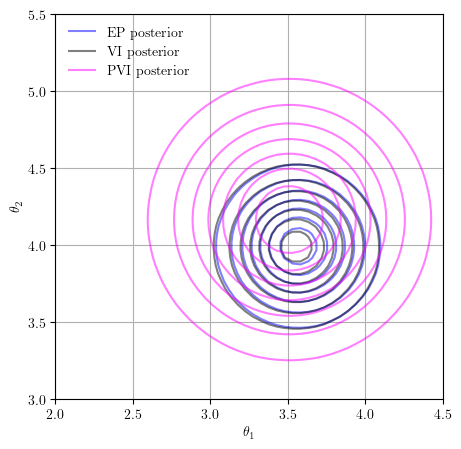

In [396]:
x = np.linspace(2,4.5)
y = np.linspace(3,5.5)
X_q, Y_q = np.meshgrid(x, y)
plt.figure(figsize=(5,5))



Z_ep = Normal(q_new_ep_bi_2d["mean"], q_new_ep_bi_2d["variance"], [X_q, Y_q], parameters["D"])
Z_pvi = Normal(q_new_bi_2d["loc"].detach().squeeze().numpy(), q_new_bi_2d["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters["D"])

Z_vi = Normal(q_new_bi_2d_vi["loc"].detach().squeeze().numpy(), q_new_bi_2d_vi["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters["D"])

Z_true = Normal(np.array([4.,4.]), 1., [X_q, Y_q], parameters["D"])
Z_ = Mixture([X_q, Y_q], 0.5, [4.,4.], 1., [0.,0.], .75, 2)

c1 = plt.contour(X_q,Y_q,Z_ep, colors='blue', alpha=.5)
c2 = plt.contour(X_q,Y_q,Z_vi, colors = "black", alpha=.5)
c3 = plt.contour(X_q,Y_q,Z_pvi, colors = "magenta", alpha=.5)
#c4 = plt.contour(X_q,Y_q,Z_true, colors = "firebrick", alpha=.5)
#c5 = plt.contour(X_q,Y_q,Z_, colors = "grey", alpha=.5)
#c4=plt.scatter(true_samples_2d[:,0], true_samples_2d[:,1], label="true data", alpha=.5)
#c5=plt.scatter(noise_samples_2d[:,0], noise_samples_2d[:,1], label="noisy data", color='orange', alpha=.5)

h1,_=c1.legend_elements()
h2,_=c2.legend_elements()
h3,_=c3.legend_elements()
h4,_=c4.legend_elements()
h5,_=c5.legend_elements()
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")

plt.legend([h1[0],h2[0], h3[0]], [r"EP posterior", r"VI posterior", "PVI posterior"], loc="upper left", frameon=False)

#plt.legend([h1[0],h2[0], h3[0], h4[0], h5[0]], [r"EP posterior", r"VI posterior", "PVI posterior", "True Distribution", r"$p(D|\theta)$"], loc="upper left", frameon=False)
plt.grid(visible=True)
#plt.grid(visible=True, alpha=.1)
plt.savefig('bimodal_2d.pgf', pad_inches=0)
plt.show()

## Section 3.7.3 Number of Clients
### 2-D case

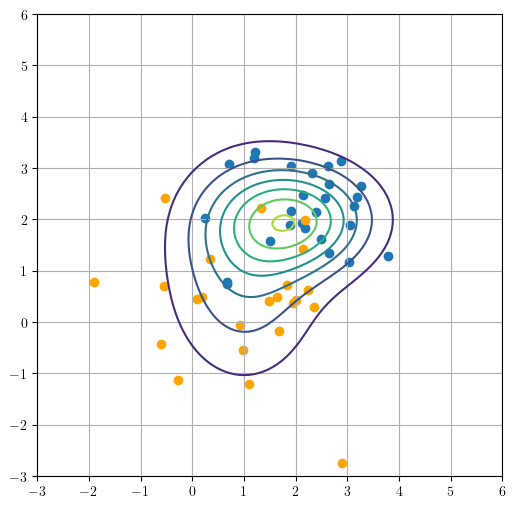

In [510]:
#Defining the model and sampling data points
D = 2

mean_1_cli = 2*torch.ones(D)
var_1_cli = torch.tensor([[1., 0],[0,.5]])
mean_2_cli = torch.ones(D)
var_2_cli = torch.tensor([[1., 0],[0,2.]])
w = 0.5

samples_cli = Gaussian.HeterogenousSampleMix([mean_1_cli,mean_2_cli], [var_1_cli,var_2_cli], torch.tensor([1-w,w]), 50)
true_samples_cli = samples_cli[0]
noise_samples_cli = samples_cli[1]
samples_cli_ = torch.cat((true_samples_cli, noise_samples_cli))
samp_cli = samples_cli_.numpy()

rndint = np.random.default_rng(86_960_949)
wait = rndint.integers(8, size=num_clients)
plt.figure(figsize=(6,6))
X = np.linspace(-3,6, 100)
Y = np.linspace(-3,6,100)
X, Y = np.meshgrid(X,Y)
pos = np.dstack((X,Y))
rv = multivariate_normal(mean_1_cli.numpy(), var_1_cli.numpy())
rv2 = multivariate_normal(mean_2_cli.numpy(), var_2_cli.numpy())
Z = rv.pdf(pos)
Z2 = rv2.pdf(pos)
trial = (1-w) * Z + w * Z2
#plt.contour(X,Y,Z)
#plt.contour(X,Y,Z2, colors=cmap1)
plt.contour(X,Y,trial)
#Z_ = Gaussian.GaussianMixture([mean_1_gaus,mean_2_gaus], [var_1_gaus,var_2_gaus], torch.tensor(A), torch.tensor([.75,.25]))

#plt.contour(X_,Y_,Z_, colors=cmap1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
plt.scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=1)
plt.scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=1)

plt.grid(visible=True)

In [511]:
samples_1 = homogeneous_split(samples_cli_, 1)
samples_2 = homogeneous_split(samples_cli_, 2)
samples_3 = homogeneous_split(samples_cli_, 3)
samples_4 = homogeneous_split(samples_cli_, 4)
samples_5 = homogeneous_split(samples_cli_, 5)
samples_6 = homogeneous_split(samples_cli_, 6)
samples_8 = homogeneous_split(samples_cli_, 8)
samples_10 = homogeneous_split(samples_cli_, 10)
samples_12 = homogeneous_split(samples_cli_, 12)
samples_15 = homogeneous_split(samples_cli_, 15)
samples_17 = homogeneous_split(samples_cli_, 17)
samples_20 = homogeneous_split(samples_cli_, 20)
samples_25 = homogeneous_split(samples_cli_, 25)
samples_50 = homogeneous_split(samples_cli_, 50)

samples_list = [samples_1, samples_2, samples_3, samples_4, samples_5, samples_6, samples_8, samples_10,
                samples_12, samples_15, samples_17, samples_20, samples_25,samples_50]

In [512]:
ten = torch.tensor([10.,10.])
torch.nn.Parameter(torch.diag_embed(ten))

Parameter containing:
tensor([[10.,  0.],
        [ 0., 10.]], requires_grad=True)

In [513]:
parameters_base = {
    "w": torch.tensor(0.5),
    "a": var_2_cli,
    "b": torch.tensor([[10.,0.],[0.,10.]]),
    "D": 2,
    "N": 32,
    "Epochs": 75,
    "Divergence": "KLD",
    "lr": 0.001,
    "samples": 50,
    "optim_epochs": 50,
    "batch_size": 10
}

q_global_base = {
    "loc": torch.nn.Parameter(torch.tensor([0.,0.])),
    "var": torch.nn.Parameter(torch.diag_embed(torch.tensor([10.,10.]))),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_base = {
        "client_idx": None,
        "x_n": None,
        "mean": torch.tensor([0., 0.]),
        "variance": np.inf * torch.diag_embed(torch.ones(2)),
        "variance_inverse": 0*torch.diag_embed(torch.ones(2)),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": var_1_cli,
        "noise_m": mean_1_cli,
        "noise_v": var_2_cli,
        "spherical": False,
        "require_s_n": False
    }

In [514]:
qs=[]
client_list = []
for samples in samples_list:
    temp = copy.deepcopy(q_global_base)
    qs.append(temp)
    cl = []
    for i in range(len(samples)):
        temp = copy.deepcopy(clients_base)
        temp.update({"client_idx": i, "x_n": samples[i]})
        cl.append(temp)
    client_list.append(cl)

In [ ]:
parameters_base.update({"Epochs":10, "optim_epochs": 2000})
q_new_1, _ = PartitionedVariationalInference(qs[0], client_list[0], parameters_base, minibatch=True)
parameters_base.update({"Epochs":75, "optim_epochs": 100})
q_new_2, _ = PartitionedVariationalInference(qs[1], client_list[1], parameters_base, minibatch=True)
q_new_3, _ = PartitionedVariationalInference(qs[2], client_list[2], parameters_base, minibatch=True)
parameters_base.update({"Epochs":125,"optim_epochs": 50})
q_new_4, _ = PartitionedVariationalInference(qs[3], client_list[3], parameters_base)
parameters_base.update({"optim_epochs": 40})
q_new_5, _ = PartitionedVariationalInference(qs[4], client_list[4], parameters_base)
q_new_6, _ = PartitionedVariationalInference(qs[5], client_list[5], parameters_base)
q_new_8, _ = PartitionedVariationalInference(qs[6], client_list[6], parameters_base)
q_new_10, _ = PartitionedVariationalInference(qs[7], client_list[7], parameters_base)
q_new_12, _ = PartitionedVariationalInference(qs[8], client_list[8], parameters_base)
q_new_15, _ = PartitionedVariationalInference(qs[9], client_list[9], parameters_base)
q_new_17, _ = PartitionedVariationalInference(qs[10], client_list[10], parameters_base)
q_new_20, _ = PartitionedVariationalInference(qs[11], client_list[11], parameters_base)
q_new_25, _ = PartitionedVariationalInference(qs[12], client_list[12], parameters_base)
q_new_50, _ = PartitionedVariationalInference(qs[13], client_list[13], parameters_base)


Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([[10.,  0.],
        [ 0., 10.]], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([0.4777, 0.3882], requires_grad=True) 
 var:  Parameter containing:
tensor([[8.1131, 0.2633],
        [0.2633, 8.1363]], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([0.5645, 0.5390], requires_grad=True) 
 var:  Parameter containing:
tensor([[6.1337, 0.7548],
        [0.7548, 6.2058]], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([0.6210, 0.6137], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.0993, 1.9898],
        [1.9898, 4.2239]], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([0.7534, 0.6717], requires_grad=True) 
 var:  Parameter containing:
tensor([[2.7811, 2.6421],


In [ ]:
X = np.linspace(-3.5,8.5, 1000)
Y = np.linspace(-3.5,8.5,1000)
X, Y = np.meshgrid(X,Y)
pos = np.dstack((X,Y))

rv = multivariate_normal(q_new_1["loc"].detach().numpy(), q_new_1["var"].detach().numpy())
Z1 = rv.pdf(pos)
rv = multivariate_normal(q_new_2["loc"].detach().numpy(), q_new_2["var"].detach().numpy())
Z2 = rv.pdf(pos)
rv = multivariate_normal(q_new_3["loc"].detach().numpy(), q_new_3["var"].detach().numpy())
Z3 = rv.pdf(pos)
rv = multivariate_normal(q_new_4["loc"].detach().numpy(), q_new_4["var"].detach().numpy())
Z4 = rv.pdf(pos)
rv = multivariate_normal(q_new_5["loc"].detach().numpy(), q_new_5["var"].detach().numpy())
Z5 = rv.pdf(pos)
rv = multivariate_normal(q_new_6["loc"].detach().numpy(), q_new_6["var"].detach().numpy())
Z6 = rv.pdf(pos)
rv = multivariate_normal(q_new_8["loc"].detach().numpy(), q_new_8["var"].detach().numpy())
Z8 = rv.pdf(pos)
rv = multivariate_normal(q_new_10["loc"].detach().numpy(), q_new_10["var"].detach().numpy())
Z10 = rv.pdf(pos)
rv = multivariate_normal(q_new_12["loc"].detach().numpy(), q_new_12["var"].detach().numpy())
Z12 = rv.pdf(pos)
rv = multivariate_normal(q_new_15["loc"].detach().numpy(), q_new_15["var"].detach().numpy())
Z15 = rv.pdf(pos)
rv = multivariate_normal(q_new_17["loc"].detach().numpy(), q_new_17["var"].detach().numpy())
Z17 = rv.pdf(pos)
rv = multivariate_normal(q_new_20["loc"].detach().numpy(), q_new_20["var"].detach().numpy())
Z20 = rv.pdf(pos)
rv = multivariate_normal(q_new_25["loc"].detach().numpy(), q_new_25["var"].detach().numpy())
Z25 = rv.pdf(pos)
rv = multivariate_normal(q_new_50["loc"].detach().numpy(), q_new_50["var"].detach().numpy())
Z50 = rv.pdf(pos)


fig, axs = plt.subplots(3,5, figsize=(9,15))
    
#fig.figure(figsize=(6,6), dpi=125)
axs[0,0].set_title(r"1 Client")
axs[0,0].contour(X,Y,Z1)
axs[0,0].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[0,0].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[0,0].grid(visible=True)

axs[0,1].set_title(r"2 Clients")
axs[0,1].contour(X,Y,Z2)
axs[0,1].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[0,1].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[0,1].grid(visible=True)

axs[0,2].set_title(r"3 Clients")
axs[0,2].contour(X,Y,Z3)
axs[0,2].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[0,2].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[0,2].grid(visible=True)

axs[1,0].set_title(r"4 Client")
axs[1,0].contour(X,Y,Z4)
axs[1,0].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[1,0].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[1,0].grid(visible=True)

axs[1,1].set_title(r"5 Clients")
axs[1,1].contour(X,Y,Z5)
axs[1,1].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[1,1].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[1,1].grid(visible=True)

axs[1,2].set_title(r"6 Clients")
axs[1,2].contour(X,Y,Z6)
axs[1,2].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[1,2].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[1,2].grid(visible=True)

axs[2,0].set_title(r"8 Client")
axs[2,0].contour(X,Y,Z8)
axs[2,0].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[2,0].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[2,0].grid(visible=True)

axs[2,1].set_title(r"10 Clients")
axs[2,1].contour(X,Y,Z10)
axs[2,1].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[2,1].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[2,1].grid(visible=True)

axs[2,2].set_title(r"12 Clients")
axs[2,2].contour(X,Y,Z12)
axs[2,2].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[2,2].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[2,2].grid(visible=True)

axs[3,0].set_title(r"15 Client")
axs[3,0].contour(X,Y,Z15)
axs[3,0].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[3,0].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[3,0].grid(visible=True)

axs[3,1].set_title(r"17 Clients")
axs[3,1].contour(X,Y,Z17)
axs[3,1].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[3,1].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[3,1].grid(visible=True)

axs[3,2].set_title(r"20 Clients")
axs[3,2].contour(X,Y,Z20)
axs[3,2].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[3,2].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[3,2].grid(visible=True)

axs[4,0].set_title(r"25 Client")
axs[4,0].contour(X,Y,Z25)
axs[4,0].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[4,0].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[4,0].grid(visible=True)

axs[4,1].set_title(r"50 Clients")
axs[4,1].contour(X,Y,Z50)
axs[4,1].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[4,1].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[4,1].grid(visible=True)
    
plt.show()

## Section 3.7.4 Update Schedule

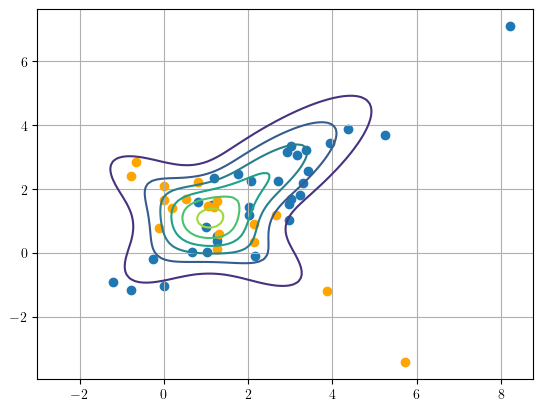

In [421]:
#Defining the model and sampling data points
D = 2

mean_1_gaus = 2*torch.ones(D)
var_1_gaus = torch.tensor([[3., 2.5],[2.5,3.]])
mean_2_gaus = torch.ones(D)
var_2_gaus = torch.tensor([[2.5, -1.8],[-1.8,2.]])
w_mult = 0.35
num_clients = 10

samples_gaus = Gaussian.HeterogenousSampleMix([mean_1_gaus,mean_2_gaus], [var_1_gaus,var_2_gaus], torch.tensor([.65,.35]), 50)
true_samples_gaus = samples_gaus[0]
noise_samples_gaus = samples_gaus[1]
samples_gaus = torch.cat((true_samples_gaus, noise_samples_gaus))
samp_gaus = samples_gaus.numpy()
client_data_gaus = homogeneous_split(samples_gaus,num_clients)

rndint = np.random.default_rng(86_960_949)
wait = rndint.integers(8, size=num_clients)

X = np.linspace(-3,7, 100)
Y = np.linspace(-3,7,100)
X, Y = np.meshgrid(X,Y)
pos = np.dstack((X,Y))
rv = multivariate_normal(mean_1_gaus.numpy(), var_1_gaus.numpy())
rv2 = multivariate_normal(mean_2_gaus.numpy(), var_2_gaus.numpy())
Z = rv.pdf(pos)
Z2 = rv2.pdf(pos)
trial = 0.65 * Z + 0.35 * Z2
#plt.contour(X,Y,Z)
#plt.contour(X,Y,Z2, colors=cmap1)
plt.contour(X,Y,trial)
#Z_ = Gaussian.GaussianMixture([mean_1_gaus,mean_2_gaus], [var_1_gaus,var_2_gaus], torch.tensor(A), torch.tensor([.75,.25]))

#plt.contour(X_,Y_,Z_, colors=cmap1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
plt.scatter(true_samples_gaus[:,0], true_samples_gaus[:,1], alpha=1)
plt.scatter(noise_samples_gaus[:,0], noise_samples_gaus[:,1],c="orange", alpha=1)

plt.grid(visible=True)

In [426]:
parameters_gaus = {
    "w": torch.tensor(0.35),
    "a": var_2_gaus,
    "b": torch.tensor([[10.,0.],[0.,10.]]),
    "D": 2,
    "N": 50,
    "Epochs": 100,
    "Divergence": "KLD",
    "lr": 5e-4,
    "samples": 50,
    "optim_epochs": 50,
    "batch_size": 16
}

q_global_gaus = {
    "loc": torch.nn.Parameter(torch.tensor([0.,0.])),
    "var": torch.nn.Parameter(torch.tensor([[10.,0.],[0.,10.]])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_gaus = []
for i in range(num_clients):
    clients_gaus.append({
        "client_idx": i,
        "x_n": client_data_gaus[i],
        "mean": torch.tensor([0., 0.]),
        "variance": np.inf * torch.eye(2),
        "variance_inverse": 0*torch.eye(2),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": var_1_gaus,
        "noise_m": mean_1_gaus,
        "noise_v": var_2_gaus,
        "spherical": False,
        "require_s_n": False,
        "wait_time": wait[i],
        "q_new": {
            "loc": None,
            "var": None
        },
        "q_old": {
            "loc": None,
            "var": None
        }
    })
#print(clients_gaus)
global_qs = []
list_clients = []
for i in range(3):
    temp_g = copy.deepcopy(q_global_gaus)
    temp_c = copy.deepcopy(clients_gaus)
    global_qs.append(temp_g)
    list_clients.append(temp_c)


q_seq, _ = PartitionedVariationalInference(global_qs[0], list_clients[0], parameters_gaus)
q_sync, _ = SynchronousPVI(global_qs[1], list_clients[1], parameters_gaus)
q_async, _ = AsynchronousPVI(global_qs[2], list_clients[2], parameters_gaus)


Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([[10.,  0.],
        [ 0., 10.]], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([0.1360, 0.0430], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.7757, 0.1878],
        [0.1878, 9.7615]], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([0.2578, 0.1102], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.5541, 0.3747],
        [0.3747, 9.5225]], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([0.3675, 0.1745], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.3321, 0.5627],
        [0.5627, 9.2858]], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([0.4757, 0.2351], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.1015, 0.7573],


New global q: 
 loc:  Parameter containing:
tensor([1.6568, 1.3622], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.4189, 4.3408],
        [4.3408, 4.3078]], requires_grad=True)
Iteration 34:
New global q: 
 loc:  Parameter containing:
tensor([1.6705, 1.3757], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.3770, 4.2983],
        [4.2983, 4.2658]], requires_grad=True)
Iteration 35:
New global q: 
 loc:  Parameter containing:
tensor([1.6745, 1.3767], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.3370, 4.2602],
        [4.2602, 4.2268]], requires_grad=True)
Iteration 36:
New global q: 
 loc:  Parameter containing:
tensor([1.6854, 1.3890], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.2933, 4.2168],
        [4.2168, 4.1867]], requires_grad=True)
Iteration 37:
New global q: 
 loc:  Parameter containing:
tensor([1.6987, 1.3962], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.2529, 4.1792],
        [4.1792, 4.1470]], requ

New global q: 
 loc:  Parameter containing:
tensor([1.8245, 1.5114], requires_grad=True) 
 var:  Parameter containing:
tensor([[3.0499, 2.9752],
        [2.9752, 2.9484]], requires_grad=True)
Iteration 67:
New global q: 
 loc:  Parameter containing:
tensor([1.8276, 1.5127], requires_grad=True) 
 var:  Parameter containing:
tensor([[3.0047, 2.9331],
        [2.9331, 2.9043]], requires_grad=True)
Iteration 68:
New global q: 
 loc:  Parameter containing:
tensor([1.8258, 1.5153], requires_grad=True) 
 var:  Parameter containing:
tensor([[2.9595, 2.8879],
        [2.8879, 2.8596]], requires_grad=True)
Iteration 69:
New global q: 
 loc:  Parameter containing:
tensor([1.8279, 1.5150], requires_grad=True) 
 var:  Parameter containing:
tensor([[2.9141, 2.8456],
        [2.8456, 2.8148]], requires_grad=True)
Iteration 70:
New global q: 
 loc:  Parameter containing:
tensor([1.8338, 1.5200], requires_grad=True) 
 var:  Parameter containing:
tensor([[2.8744, 2.8024],
        [2.8024, 2.7761]], requ

New global q: 
 loc:  Parameter containing:
tensor([1.8554, 1.5417], requires_grad=True) 
 var:  Parameter containing:
tensor([[1.5272, 1.4776],
        [1.4776, 1.4665]], requires_grad=True)
Iteration 100:
New global q: 
 loc:  Parameter containing:
tensor([1.8553, 1.5435], requires_grad=True) 
 var:  Parameter containing:
tensor([[1.4800, 1.4287],
        [1.4287, 1.4189]], requires_grad=True)
Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([[10.,  0.],
        [ 0., 10.]], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([0.1343, 0.0591], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.7870, 0.1777],
        [0.1777, 9.7720]], requires_grad=True)
Iteration 2:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Cli

Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([1.2811, 0.9975], requires_grad=True) 
 var:  Parameter containing:
tensor([[5.0833, 4.4096],
        [4.4096, 4.9555]], requires_grad=True)
Iteration 24:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([1.2925, 1.0211], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.9401, 4.5463],
        [4.5463, 4.8119]], requires_grad=True)
Iteration 25:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([1.3039, 1.0406], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.8315, 4.6412],
        [4.6412, 4.7036]], requires_grad=True)
Iteration 26:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter

Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([1.7281, 1.4235], requires_grad=True) 
 var:  Parameter containing:
tensor([[3.9436, 3.8707],
        [3.8707, 3.8435]], requires_grad=True)
Iteration 48:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([1.7296, 1.4249], requires_grad=True) 
 var:  Parameter containing:
tensor([[3.8993, 3.8274],
        [3.8274, 3.7991]], requires_grad=True)
Iteration 49:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([1.7299, 1.4237], requires_grad=True) 
 var:  Parameter containing:
tensor([[3.8603, 3.7871],
        [3.7871, 3.7599]], requires_grad=True)
Iteration 50:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([1.7210, 1.4197]

Client 9
New global q: 
 loc:  Parameter containing:
tensor([1.8095, 1.4900], requires_grad=True) 
 var:  Parameter containing:
tensor([[2.9612, 2.8880],
        [2.8880, 2.8606]], requires_grad=True)
Iteration 72:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([1.8113, 1.4932], requires_grad=True) 
 var:  Parameter containing:
tensor([[2.9145, 2.8454],
        [2.8454, 2.8152]], requires_grad=True)
Iteration 73:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([1.8154, 1.4929], requires_grad=True) 
 var:  Parameter containing:
tensor([[2.8735, 2.8033],
        [2.8033, 2.7743]], requires_grad=True)
Iteration 74:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([1.8205, 1.4999], requires_grad=True) 
 var:  Parame

Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([1.8388, 1.5245], requires_grad=True) 
 var:  Parameter containing:
tensor([[1.7917, 1.7358],
        [1.7358, 1.7222]], requires_grad=True)
Iteration 97:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([1.8512, 1.5333], requires_grad=True) 
 var:  Parameter containing:
tensor([[1.7469, 1.6892],
        [1.6892, 1.6758]], requires_grad=True)
Iteration 98:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([1.8537, 1.5387], requires_grad=True) 
 var:  Parameter containing:
tensor([[1.6952, 1.6410],
        [1.6410, 1.6262]], requires_grad=True)
Iteration 99:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter

Client 6 with wait time:  1
Client 7 with wait time:  4
Client 8 with wait time:  0
Client 9 with wait time:  4
New global q: 
 loc:  Parameter containing:
tensor([1.1747, 0.4218], requires_grad=True) 
 var:  Parameter containing:
tensor([[8.4575, 1.0040],
        [1.0040, 8.2912]], requires_grad=True)
Iteration 17:
Client 4 with wait time:  1
Client 6 with wait time:  1
Client 8 with wait time:  0
New global q: 
 loc:  Parameter containing:
tensor([1.2381, 0.4279], requires_grad=True) 
 var:  Parameter containing:
tensor([[8.3953, 1.0330],
        [1.0330, 8.2233]], requires_grad=True)
Iteration 18:
Client 0 with wait time:  6
Client 3 with wait time:  2
Client 4 with wait time:  1
Client 5 with wait time:  3
Client 6 with wait time:  1
Client 8 with wait time:  0
New global q: 
 loc:  Parameter containing:
tensor([1.2546, 0.4762], requires_grad=True) 
 var:  Parameter containing:
tensor([[8.2739, 1.1237],
        [1.1237, 8.0925]], requires_grad=True)
Iteration 19:
Client 4 with wait

New global q: 
 loc:  Parameter containing:
tensor([1.9427, 1.0650], requires_grad=True) 
 var:  Parameter containing:
tensor([[6.2648, 2.5952],
        [2.5952, 6.0728]], requires_grad=True)
Iteration 38:
Client 3 with wait time:  2
Client 4 with wait time:  1
Client 6 with wait time:  1
Client 8 with wait time:  0
New global q: 
 loc:  Parameter containing:
tensor([1.9751, 1.0854], requires_grad=True) 
 var:  Parameter containing:
tensor([[6.1728, 2.6761],
        [2.6761, 5.9827]], requires_grad=True)
Iteration 39:
Client 4 with wait time:  1
Client 5 with wait time:  3
Client 6 with wait time:  1
Client 8 with wait time:  0
New global q: 
 loc:  Parameter containing:
tensor([2.0024, 1.1065], requires_grad=True) 
 var:  Parameter containing:
tensor([[6.0833, 2.7600],
        [2.7600, 5.8940]], requires_grad=True)
Iteration 40:
Client 2 with wait time:  4
Client 3 with wait time:  2
Client 4 with wait time:  1
Client 6 with wait time:  1
Client 7 with wait time:  4
Client 8 with wait

Client 6 with wait time:  1
Client 8 with wait time:  0
New global q: 
 loc:  Parameter containing:
tensor([2.2077, 1.5508], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.4205, 4.2772],
        [4.2772, 4.2603]], requires_grad=True)
Iteration 60:
Client 0 with wait time:  6
Client 2 with wait time:  4
Client 3 with wait time:  2
Client 4 with wait time:  1
Client 5 with wait time:  3
Client 6 with wait time:  1
Client 7 with wait time:  4
Client 8 with wait time:  0
Client 9 with wait time:  4
New global q: 
 loc:  Parameter containing:
tensor([2.2215, 1.6463], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.3756, 4.2560],
        [4.2560, 4.2082]], requires_grad=True)
Iteration 61:
Client 4 with wait time:  1
Client 6 with wait time:  1
Client 8 with wait time:  0
New global q: 
 loc:  Parameter containing:
tensor([2.2523, 1.6674], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.3537, 4.2412],
        [4.2412, 4.2020]], requires_grad=True)
Iter

Client 8 with wait time:  0
Client 9 with wait time:  4
New global q: 
 loc:  Parameter containing:
tensor([2.2942, 1.9041], requires_grad=True) 
 var:  Parameter containing:
tensor([[3.9524, 3.8678],
        [3.8678, 3.8254]], requires_grad=True)
Iteration 81:
Client 4 with wait time:  1
Client 5 with wait time:  3
Client 6 with wait time:  1
Client 8 with wait time:  0
New global q: 
 loc:  Parameter containing:
tensor([2.2883, 1.9009], requires_grad=True) 
 var:  Parameter containing:
tensor([[3.9340, 3.8521],
        [3.8521, 3.8096]], requires_grad=True)
Iteration 82:
Client 3 with wait time:  2
Client 4 with wait time:  1
Client 6 with wait time:  1
Client 8 with wait time:  0
New global q: 
 loc:  Parameter containing:
tensor([2.2860, 1.9003], requires_grad=True) 
 var:  Parameter containing:
tensor([[3.9209, 3.8402],
        [3.8402, 3.7967]], requires_grad=True)
Iteration 83:
Client 4 with wait time:  1
Client 6 with wait time:  1
Client 8 with wait time:  0
New global q: 
 lo

In [422]:
#VI implementation
parameters_gaus_vi = {
    "w": torch.tensor(0.35),
    "a": var_2_gaus,
    "b": torch.tensor([[10.,0.],[0.,10.]]),
    "D": 2,
    "N": 50,
    "Epochs": 2,
    "Divergence": "KLD",
    "lr": 0.002,
    "samples": 50,
    "optim_epochs": 2000,
    "batch_size": 20
}

q_global_gaus_vi = {
    "loc": torch.nn.Parameter(torch.tensor([0.,0.])),
    "var": torch.nn.Parameter(torch.tensor([[10.,0.],[0.,10.]])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_gaus_vi = []
clients_gaus_vi.append({
    "client_idx": i,
    "x_n": samples_gaus,
    "mean": torch.tensor([0., 0.]),
    "variance": np.inf * torch.eye(2),
    "variance_inverse": 0*torch.eye(2),
    "normaliser": torch.tensor(1.),
    "iteration": 0,
    "true_v": var_1_gaus,
    "noise_m": mean_1_gaus,
    "noise_v": var_2_gaus,
    "spherical": False,
    "require_s_n": False,
})
q_gaus_vi, _ = PartitionedVariationalInference(q_global_gaus_vi, clients_gaus_vi, parameters_gaus_vi, minibatch=True)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([[10.,  0.],
        [ 0., 10.]], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
Cavity Distribution:  Parameter containing:
tensor([1.6060, 1.2293], requires_grad=True) Parameter containing:
tensor([[5.2855, 4.7547],
        [4.7547, 5.3170]], requires_grad=True)
New global q: 
 loc:  Parameter containing:
tensor([1.6060, 1.2293], requires_grad=True) 
 var:  Parameter containing:
tensor([[5.2855, 4.7547],
        [4.7547, 5.3170]], requires_grad=True)
Iteration 2:
Cavity Distribution:  Parameter containing:
tensor([1.8093, 1.4950], requires_grad=True) Parameter containing:
tensor([[4.4786, 4.4148],
        [4.4148, 4.3941]], requires_grad=True)
New global q: 
 loc:  Parameter containing:
tensor([1.8093, 1.4950], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.4786, 4.4148],
        [4.4148, 4.3941]], requires_grad=T

In [423]:
parameters_gaus_vi.update({"Epochs": 1})
q_gaus_vi, _ = PartitionedVariationalInference(q_global_gaus_vi, clients_gaus_vi, parameters_gaus_vi, minibatch=True)

Starting global q:  {'loc': Parameter containing:
tensor([1.8093, 1.4950], requires_grad=True), 'var': Parameter containing:
tensor([[4.4786, 4.4148],
        [4.4148, 4.3941]], requires_grad=True), 'metrics': {'elbos': [-215.00423675759703, -245.2386167547527], 'kls': [1.1794069957998126, 2.851888311544088], 'lls': [0.0, 0.0]}}
Iteration 1:
Cavity Distribution:  Parameter containing:
tensor([1.8398, 1.5107], requires_grad=True) Parameter containing:
tensor([[3.6848, 3.6151],
        [3.6151, 3.5752]], requires_grad=True)
New global q: 
 loc:  Parameter containing:
tensor([1.8398, 1.5107], requires_grad=True) 
 var:  Parameter containing:
tensor([[3.6848, 3.6151],
        [3.6151, 3.5752]], requires_grad=True)


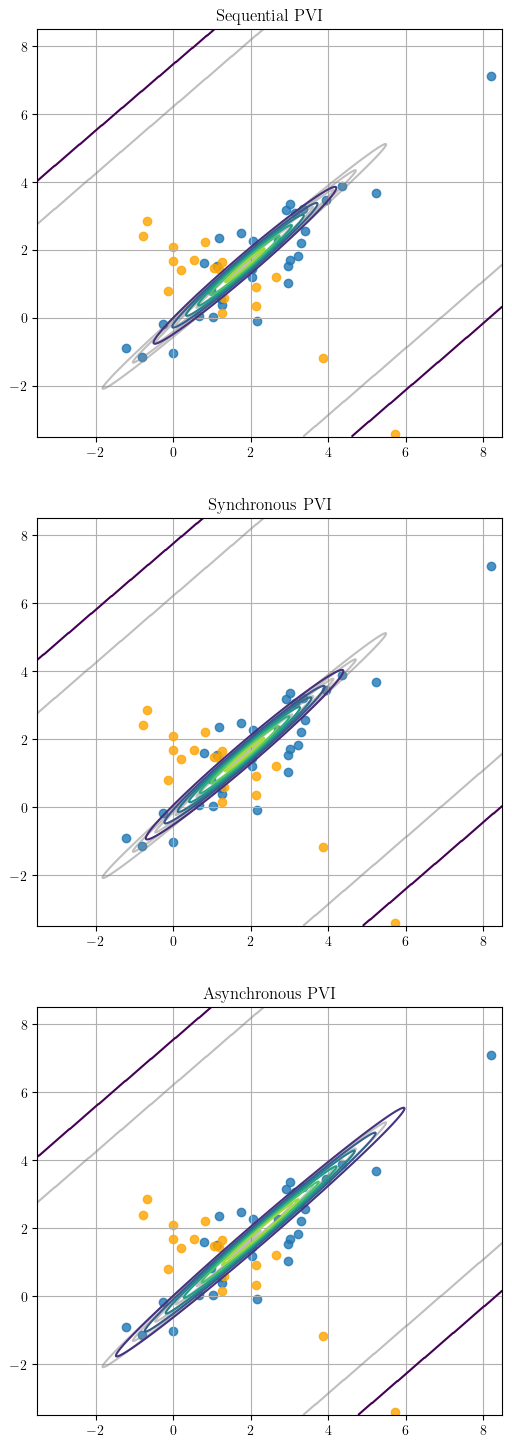

In [472]:
X = np.linspace(-3.5,8.5, 1000)
Y = np.linspace(-3.5,8.5,1000)
X, Y = np.meshgrid(X,Y)
pos = np.dstack((X,Y))

rv = multivariate_normal(q_seq["loc"].detach().numpy(), q_seq["var"].detach().numpy())
Z = rv.pdf(pos)
rvsync = multivariate_normal(q_sync["loc"].detach().numpy(), q_sync["var"].detach().numpy())
Zsync = rvsync.pdf(pos)
rvasync = multivariate_normal(q_async["loc"].detach().numpy(), q_async["var"].detach().numpy())
Zasync = rvasync.pdf(pos)
rvvi = multivariate_normal(q_gaus_vi["loc"].detach().numpy(), q_gaus_vi["var"].detach().numpy())
Z_vi = rvvi.pdf(pos)
#plt.scatter(samples_gaus[:,0], samples_gaus[:,1], c="steelblue", alpha=.8)
#plt.grid(visible=True)


fig, axs = plt.subplots(3,1, figsize=(6,18))

for ax in axs:
    ax.contour(X,Y,Z_vi, colors="grey", alpha=.5)
    
#fig.figure(figsize=(6,6), dpi=125)
axs[0].set_title(r"Sequential PVI")
axs[0].contour(X,Y,Z)
axs[0].scatter(true_samples_gaus[:,0], true_samples_gaus[:,1], alpha=.8)
axs[0].scatter(noise_samples_gaus[:,0], noise_samples_gaus[:,1],c="orange", alpha=.8)
axs[0].grid(visible=True)

axs[1].set_title(r"Synchronous PVI")
axs[1].contour(X,Y,Zsync)
axs[1].scatter(true_samples_gaus[:,0], true_samples_gaus[:,1], alpha=.8)
axs[1].scatter(noise_samples_gaus[:,0], noise_samples_gaus[:,1],c="orange", alpha=.8)
axs[1].grid(visible=True)

axs[2].set_title(r"Asynchronous PVI")
axs[2].contour(X,Y,Zasync)
axs[2].scatter(true_samples_gaus[:,0], true_samples_gaus[:,1], alpha=.8)
axs[2].scatter(noise_samples_gaus[:,0], noise_samples_gaus[:,1],c="orange", alpha=.8)
axs[2].grid(visible=True)
    
plt.show()

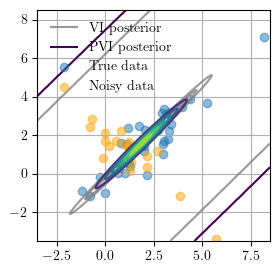

In [485]:
plt.figure(figsize=(3,3))


c2 = plt.contour(X,Y,Z_vi, colors = "grey", alpha=.8)
c3 = plt.contour(X,Y,Z, alpha=1)
#c4 = plt.contour(X_q,Y_q,Z_true, colors = "firebrick", alpha=.5)
#c5 = plt.contour(X_q,Y_q,Z_, colors = "grey", alpha=.5)

c4=plt.scatter(true_samples_gaus[:,0], true_samples_gaus[:,1], label="true data", alpha=.5)
c5=plt.scatter(noise_samples_gaus[:,0], noise_samples_gaus[:,1], label="noisy data", color='orange', alpha=.5)

h2,_=c2.legend_elements()
h3,_=c3.legend_elements()
#plt.xlabel(r"$\theta_1$")
#plt.ylabel(r"$\theta_2$")

plt.legend([h2[0], h3[0], c4, c5], [r"VI posterior", "PVI posterior", "True data", "Noisy data"], loc="upper left", frameon=False)

#plt.legend([h1[0],h2[0], h3[0], h4[0], h5[0]], [r"EP posterior", r"VI posterior", "PVI posterior", "True Distribution", r"$p(D|\theta)$"], loc="upper left", frameon=False)
plt.grid(visible=True)
#plt.grid(visible=True, alpha=.1)
plt.savefig('seq_pvi.pgf', pad_inches=0)
plt.show()

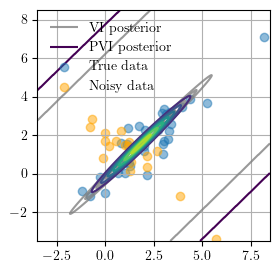

In [486]:
plt.figure(figsize=(3,3))


c2 = plt.contour(X,Y,Z_vi, colors = "grey", alpha=.8)
c3 = plt.contour(X,Y,Zsync, alpha=1)
#c4 = plt.contour(X_q,Y_q,Z_true, colors = "firebrick", alpha=.5)
#c5 = plt.contour(X_q,Y_q,Z_, colors = "grey", alpha=.5)

c4=plt.scatter(true_samples_gaus[:,0], true_samples_gaus[:,1], label="true data", alpha=.5)
c5=plt.scatter(noise_samples_gaus[:,0], noise_samples_gaus[:,1], label="noisy data", color='orange', alpha=.5)

h2,_=c2.legend_elements()
h3,_=c3.legend_elements()
#plt.xlabel(r"$\theta_1$")
#plt.ylabel(r"$\theta_2$")

plt.legend([h2[0], h3[0], c4, c5], [r"VI posterior", "PVI posterior", "True data", "Noisy data"], loc="upper left", frameon=False)

#plt.legend([h1[0],h2[0], h3[0], h4[0], h5[0]], [r"EP posterior", r"VI posterior", "PVI posterior", "True Distribution", r"$p(D|\theta)$"], loc="upper left", frameon=False)
plt.grid(visible=True)
#plt.grid(visible=True, alpha=.1)
plt.savefig('sync_pvi.pgf', pad_inches=0)
plt.show()

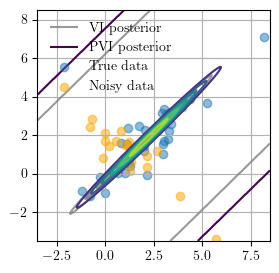

In [487]:
plt.figure(figsize=(3,3))


c2 = plt.contour(X,Y,Z_vi, colors = "grey", alpha=.8)
c3 = plt.contour(X,Y,Zasync, alpha=1)
#c4 = plt.contour(X_q,Y_q,Z_true, colors = "firebrick", alpha=.5)
#c5 = plt.contour(X_q,Y_q,Z_, colors = "grey", alpha=.5)

c4=plt.scatter(true_samples_gaus[:,0], true_samples_gaus[:,1], label="true data", alpha=.5)
c5=plt.scatter(noise_samples_gaus[:,0], noise_samples_gaus[:,1], label="noisy data", color='orange', alpha=.5)

h2,_=c2.legend_elements()
h3,_=c3.legend_elements()
#plt.xlabel(r"$\theta_1$")
#plt.ylabel(r"$\theta_2$")

plt.legend([h2[0], h3[0], c4, c5], [r"VI posterior", "PVI posterior", "True data", "Noisy data"], loc="upper left", frameon=False)

#plt.legend([h1[0],h2[0], h3[0], h4[0], h5[0]], [r"EP posterior", r"VI posterior", "PVI posterior", "True Distribution", r"$p(D|\theta)$"], loc="upper left", frameon=False)
plt.grid(visible=True)
#plt.grid(visible=True, alpha=.1)
plt.savefig('async_pvi.pgf', pad_inches=0)
plt.show()

In [476]:
#Sequential Metrics:
#Mean from VI mean, Euclidean Norm
dif = q_gaus_vi["loc"].detach() - q_seq["loc"].detach()
norm_mean = torch.linalg.vector_norm(dif)
mat_dif = q_gaus_vi["var"].detach() - q_seq["var"].detach()
norm_cov = torch.linalg.matrix_norm(mat_dif)
lsgv = torch.linalg.det(q_gaus_vi["var"].detach()).log() - torch.linalg.det(q_seq["var"].detach()).log()
print(f"Norm: {norm_mean}, Frobenius Norm: {norm_cov}, Log SGV difference: {lsgv}")

Norm: 0.03629076790145597, Frobenius Norm: 4.367143629792584, Log SGV difference: 0.5720038851944169


In [477]:
#Synchronous Metrics:
#Mean from VI mean, Euclidean Norm
dif = q_gaus_vi["loc"].detach() - q_sync["loc"].detach()
norm_mean = torch.linalg.vector_norm(dif)
mat_dif = q_gaus_vi["var"].detach() - q_sync["var"].detach()
norm_cov = torch.linalg.matrix_norm(mat_dif)
lsgv = torch.linalg.det(q_gaus_vi["var"].detach()).log() - torch.linalg.det(q_sync["var"].detach()).log()
print(f"Norm: {norm_mean}, Frobenius Norm: {norm_cov}, Log SGV difference: {lsgv}")

Norm: 0.02785529727999765, Frobenius Norm: 4.1250762228247995, Log SGV difference: 0.41713351227460205


In [478]:
#Asynchronous Metrics:
#Mean from VI mean, Euclidean Norm
dif = q_gaus_vi["loc"].detach() - q_async["loc"].detach()
norm_mean = torch.linalg.vector_norm(dif)
mat_dif = q_gaus_vi["var"].detach() - q_async["var"].detach()
norm_cov = torch.linalg.matrix_norm(mat_dif)
lsgv = torch.abs(torch.linalg.det(q_gaus_vi["var"].detach()).log() - torch.linalg.det(q_async["var"].detach()).log())
print(f"Norm: {norm_mean}, Frobenius Norm: {norm_cov}, Log SGV difference: {lsgv}")

Norm: 0.5546281793132539, Frobenius Norm: 0.19381097949376058, Log SGV difference: 0.3547042722542251


## Section 3.7.5 Theorem 11 illustration

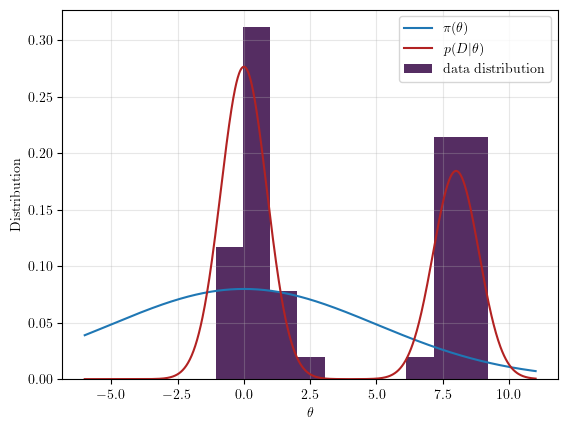

In [37]:
#Generate Data
mean_1_thm = torch.tensor([8.])
var_1_thm = torch.tensor([.75])
mean_2_thm = torch.tensor([0.])
var_2_thm = torch.tensor([.75])
w = 0.6

samples_thm = Gaussian.HeterogenousSampleMix([mean_1_thm,mean_2_thm], [var_1_thm,var_2_thm], torch.tensor([1-w,w]), 50)
true_samples_thm = samples_thm[0]
noise_samples_thm = samples_thm[1]
samples_thm = torch.cat((true_samples_thm, noise_samples_thm))
samp_thm = samples_thm.numpy()

x = np.linspace(-6, 11, 1000)

plt.plot(x, Normal(0,25,x,1), label=r"$\pi(\theta)$")
plt.plot(x, Mix(x, w, 8., .75, 0., .75), color="firebrick", label=r"$p(D|\theta)$")
plt.hist(samp_thm, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel(r"$\theta$")
plt.ylabel("Distribution")
plt.legend(loc="upper right")

plt.grid(visible=True, alpha=.3)
#plt.savefig("unimodal_mix_1d.png")
plt.show()

In [39]:
# PVI implementation
parameters_thm = {
    "w": torch.tensor(1e-200),
    "a": torch.tensor([.75]),
    "b": torch.tensor([10.]),
    "D": 1,
    "N": 50,
    "Epochs": 10,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 4000
}

q_global_thm = {
    "loc": torch.nn.Parameter(torch.tensor([0.])),
    "var": torch.nn.Parameter(parameters_thm["b"]),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}
data = [true_samples_thm, noise_samples_thm]
clients_thm = []
for i in range(1):
    clients_thm.append({
        "client_idx": i,
        "x_n": samples_thm,
        "mean": torch.tensor([0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": var_1_thm,
        "noise_m": mean_2_thm,
        "noise_v": parameters_thm["a"],
        "spherical": True,
        "require_s_n": False
    })
    
q_new_1d_thm, clients_new_1d_thm = PartitionedVariationalInference(q_global_thm, clients_thm, parameters_thm, is_1d=True)


Starting global q:  {'loc': Parameter containing:
tensor([0.], requires_grad=True), 'var': Parameter containing:
tensor([10.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([3.9306], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0866], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([3.9373], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0920], requires_grad=True)
Iteration 3:


KeyboardInterrupt: 

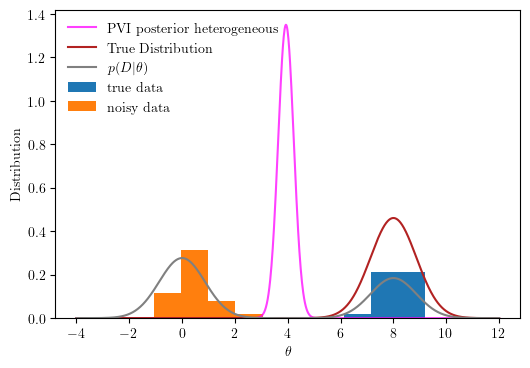

In [40]:
x = np.linspace(-4, 12, 1000)
plt.figure(figsize=(6,4))

plt.plot(x, Normal(q_global_thm["loc"].detach().squeeze().numpy(), q_global_thm["var"].detach().squeeze().numpy(), x, 1),
         label="PVI posterior heterogeneous", color='magenta', alpha=.75)

plt.plot(x, Normal(8, .75, x, 1), label="True Distribution", color='firebrick')
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, 0.6, 8., .75, 0., .75), color="grey", label=r"$p(D|\theta)$")
d = [true_samples_thm.T[0].numpy(), noise_samples_thm.T[0].numpy()]
plt.hist(d, density=True, bins=10, label=["true data", "noisy data"], histtype='bar', stacked=True)
#plt.hist(noise_samples.numpy(), density=True, bins=10, label="noisy data", color="black")

plt.xlabel(r"$\theta$")
plt.ylabel("Distribution")
plt.legend(loc="upper left", frameon=False)
#plt.grid(visible=True, alpha=.1)
#plt.savefig('thm11.pgf', pad_inches=0)
plt.show()

In [43]:
# PVI implementation
parameters_thm2 = {
    "w": torch.tensor(1e-200),
    "a": torch.tensor([.75]),
    "b": torch.tensor([10.]),
    "D": 1,
    "N": 50,
    "Epochs": 5,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 4000
}

q_global_thm2 = {
    "loc": torch.nn.Parameter(torch.tensor([0.])),
    "var": torch.nn.Parameter(parameters_thm2["b"]),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}
data = [true_samples_thm, noise_samples_thm]
clients_thm2 = []
for i in range(2):
    clients_thm2.append({
        "client_idx": i,
        "x_n": data[i],
        "mean": torch.tensor([0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": var_1_thm,
        "noise_m": mean_2_thm,
        "noise_v": parameters_thm["a"],
        "spherical": True,
        "require_s_n": False
    })
    
q_new_1d_thm2, clients_new_1d_thm2 = PartitionedVariationalInference(q_global_thm2, clients_thm2, parameters_thm2, is_1d=True)


Starting global q:  {'loc': Parameter containing:
tensor([0.], requires_grad=True), 'var': Parameter containing:
tensor([10.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([1.7921], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0734], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([2.8222], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0444], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([3.5533], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2081], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([3.7947], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0749], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([3.8589], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0645], requires_grad=True)

In [ ]:
x = np.linspace(-4, 12, 1000)
plt.figure(figsize=(6,4))

plt.plot(x, Normal(q_global_thm2["loc"].detach().squeeze().numpy(), q_global_thm2["var"].detach().squeeze().numpy(), x, 1),
         label="PVI posterior heterogeneous", color='magenta', alpha=.75)

plt.plot(x, Normal(8, .75, x, 1), label="True Distribution", color='firebrick')
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, 0.6, 8., .75, 0., .75), color="grey", label=r"$p(D|\theta)$")
d = [true_samples_thm.T[0].numpy(), noise_samples_thm.T[0].numpy()]
plt.hist(d, density=True, bins=10, label=["true data", "noisy data"], histtype='bar', stacked=True)
#plt.hist(noise_samples.numpy(), density=True, bins=10, label="noisy data", color="black")

plt.xlabel(r"$\theta$")
plt.ylabel("Distribution")
plt.legend(loc="upper left", frameon=False)
#plt.grid(visible=True, alpha=.1)
#plt.savefig('thm11.pgf', pad_inches=0)
plt.show()